# HIG-21-009: Signal parametrization

This notebook serves as a plotter for the signal parametrization used in the $H\rightarrow ZZ\rightarrow4\ell$ Full Run-II differential analysis.

The signal parametrization consists of a double sided crystal ball function obtained from the fit of the reconstructed invariant mass of the four-leptons system ($m_{4\ell}$).

The signal line shape is derived independently for each final state, data taking period, and production mechanism considered in the analysis. However, in the final measurements the signal is parametrized using the gluon-fusion p.d.f., being this the leading production mode. The results of the analsis (i.e. fiducial cross section measurements) are found to be essentially unchanged if a different parametrization is used for every production mode.

When the Higgs boson is produced in association with vector bosons ($W, Z$) or with $t\bar{t}$, there is a non-negligible probability of selecting a "wrong lepton" in the reconstruction of the four-leptons system. Hence, to cope with these cases, that result in a rise on the right tail of the $m_{4\ell}$ distribution, an Landau p.d.f. is included in the fit. In the final measurement, the Landau contribution considered is taken from the mean of the individual contributions of the $VH$ and $t\bar{t}H$ channels.

As a first step, few imports and definitions.

The expression of the double sided crystall ball used in this plotter relies on `tensorflow` and is taken from the [`zfit`](https://zfit.readthedocs.io/en/latest/user_api/pdf/_generated/basic/zfit.pdf.DoubleCB.html) code.

In [21]:
import os
import math
import uproot
import numpy as np
import mplhep as hep
import tensorflow as tf
from scipy.stats import moyal
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit
from collections import OrderedDict as od
plt.style.use(hep.style.CMS)


def landau_pdf(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*math.pi))*np.exp(-(((x-mu)/sigma)+np.exp(-((x-mu)/sigma)))/2)

def safe_where(condition, func, safe_func, values,
               value_safer) -> tf.Tensor:
    safe_x = tf.where(condition=condition, x=values, y=value_safer(values))
    result = tf.where(condition=condition, x=func(safe_x), y=safe_func(values))
    return result

def _powerlaw(x, a, k):
    return a * tf.pow(x, k)

def crystalball_func(x, mu, sigma, alpha, n):
    t = (x - mu) / sigma * tf.sign(alpha)
    abs_alpha = tf.abs(alpha)
    a = tf.pow((n / abs_alpha), n) * tf.exp(-0.5 * tf.square(alpha))
    b = (n / abs_alpha) - abs_alpha
    cond = tf.less(t, -abs_alpha)
    func = safe_where(cond,
                        lambda t: _powerlaw(b - t, a, -n),
                        lambda t: tf.exp(-0.5 * tf.square(t)),
                        values=t, value_safer=lambda t: tf.ones_like(t) * (b - 2))
    func = tf.maximum(func, tf.zeros_like(func))
    return func

In [33]:
def double_crystalball_func(x, mu, sigma, alphal, nl, alphar, nr, norm):
    cond = tf.less(x, mu)
    func = tf.where(cond,
                    crystalball_func(x, mu, sigma, alphal, nl),
                    crystalball_func(x, mu, sigma, -alphar, nr))

    return norm*func

def readFile(mass, year, pmode = 'ggH', suffix = 'redTree'):
    with uproot.open(f'/eos/user/m/mbonanom/HIG-21-009/redTrees/{pmode}{mass}_{suffix}_{year}.root') as f:
        zzmass = f['SelectedTree/ZZMass'].array(library="np")
        weight = f['SelectedTree/weight'].array(library="np")
        chan = f['SelectedTree/chan'].array(library="np")
    f.close()
    return zzmass, weight, chan

def readParams(pmode, chan, year, fname = 'file.txt', mH = '125', toDict=False):
    params = od()
    with open('%s'%fname, 'r') as f: 
        for line in f:
            _line = line.split(' ')
            _name = _line[0].split('_')[0]
            _value = _line[2].split('+')[0]
            _value = float(_value)
            if (mH!='125') and ('frac' not in _name):
                _shift = _line[2].split('+')[1].replace('\n', '')
                _shift = _shift.replace('MH', mH)

                _shift = eval(_shift)
                _value = _value + _shift
            if(_name in params): _name = _name+'_l'
            params[_name] = _value
    f.close()
    params = dict(params)
    pdf_pars = []
    PDF_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2']
    if pmode in ASSOCIATED_PRODUCTIONS:
        PDF_PARAMS.extend(['mean_l', 'sigma_l', 'frac'])
    for name in PDF_PARAMS:
        pdf_pars.append(params[name])
    if toDict:
        return params
    else:
        return pdf_pars
    
def readShifts(pmode, chan, year, fname = 'file.txt', mH = '125', toDict=False):
    params = od()
    with open('%s'%fname, 'r') as f: 
        for line in f:
            _line = line.split(' ')
            _name = _line[0].split('_')[0]
            if ('frac' not in _name):
                _shift = _line[2].split('+')[1].replace('\n', '')
                _shift = float(_shift.split('*')[0])
            else:
                _shift = 0.0
            if(_name in params): _name = _name+'_l'
            params[_name] = _shift
    f.close()
    params = dict(params)
    pdf_pars = []
    PDF_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2']
    if pmode in ASSOCIATED_PRODUCTIONS:
        PDF_PARAMS.extend(['mean_l', 'sigma_l', 'frac'])
    for name in PDF_PARAMS:
        pdf_pars.append(params[name])
    if toDict:
        return params
    else:
        return pdf_pars

def _makelegend(params):
    names = ['\\mu', '\\sigma', '\\alpha_L', 'n_L', '\\alpha_R', 'n_R']
    label = ''
    for name, value in zip(names, params):
        label += (r'$%s$ = %.2f' + '\n') %(name, value)
    return label

def _returnParams(params, fname):
    names = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'norm']
    if len(params) > len(names):
        names = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'mean_l', 'sigma_l', 'frac', 'norm']
    with open(fname, 'w') as f:
        for name, value in zip(names, params):
            if name == 'norm': continue
            f.write(f'{name}: {value}\n')
    f.close()

def _getTitle(fs, year, isUL=True):
    chanName = [r'$4\mu$', r'$4e$', r'$2e2\mu$']
    title = '%s , %i' %(chanName[fs-1], year)
    if isUL:
        title += ' , UL'
    return title

def tot_pdf(x, mu, sigma, alphal, nl, alphar, nr, mu_l, sigma_l, frac, norm):
    cond = tf.less(x, mu)
    landau = moyal.pdf(x, mu_l, sigma_l)

    func = tf.where(cond,
                    crystalball_func(x, mu, sigma, alphal, nl),
                    crystalball_func(x, mu, sigma, -alphar, nr))
    
    return func*norm*frac+landau*norm*(1-frac)

def plotPdf(pmode, zzmass, weight, chan, fs, params, year, suffix = 'redTree', label = 'Simulation', refit=True, www = '/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/param', saveResults = False, dumpToTxt = False):
    fname = f'{www}/sim_massParam_{pmode}_{suffix}_{fs}_{year}_refit.txt'
    
    x = np.linspace(105, 140, 1000)
    binning = np.linspace(105, 140, 101)
    if suffix!='redTree':
        x = np.linspace(105, 160, 1000)
        binning = np.linspace(105, 160, 101)
    n, bins = np.histogram(zzmass[chan==fs], weights=weight[chan==fs], bins = binning)
    n_err = np.sqrt(np.histogram(zzmass[chan==fs], bins=binning, weights=weight[chan==fs]**2)[0])
    n_err = n_err
    n = n
    bins = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(bins, n, yerr = n_err, marker = 'o', color = 'k', linestyle = 'None', label = label)
        
    if pmode in ASSOCIATED_PRODUCTIONS:
        frac = params[-1]
        landau = moyal.pdf(x, *params[-3:-1])*max(n)
        dcb = double_crystalball_func(x, *params[:-3], frac*max(n))
        
        if not refit:
            pdf = (dcb+landau)
#             pdf = tot_pdf(x,*params,max(n))
        else:
            popt, pcov = curve_fit(tot_pdf, bins, n, p0=[*params, max(n)])
            pdf = tot_pdf(x,*popt)
            if dumpToTxt:
                _returnParams(popt, fname)
            if saveResults:
                fitResults = popt
            
        plt.plot(x, dcb, '--', color = 'r', label = 'Double CB')
        plt.plot(x, landau, '--', color = 'darkorange', label = 'Landau')
        plt.plot(x, pdf, '-', color = 'b', label = r' pdf $m_{4\ell}$')

    else:
        frac = 1.0
        dcb = double_crystalball_func(x, *params, max(n))
        
        if not refit:
            pdf = dcb
        else:
            popt, pcov = curve_fit(double_crystalball_func, bins, n, p0=[*params, max(n)]) 
            pdf = double_crystalball_func(x,*popt)
            if saveResults:
                fitResults = popt
            if dumpToTxt:
                _returnParams(popt, fname)

        plt.plot(x, pdf, '-', color = 'b', label = r' pdf $m_{4\ell}$')
    
    if saveResults:
        return fitResults

After the definition of the helper functions above, we can produce all the plots.

The `SUFFIX` referst to whether the ntuples contain $m_{4\ell}$ reconstructed in $[105,140]$ GeV (`SUFFIX=redTree`) or in $[105,160]$ GeV (`SUFFIX=105160`).

All the plots and files will be saved under `www/WWW_DEST`.

In [23]:
ASSOCIATED_PRODUCTIONS = ["ZH", "WminusH", "WplusH", "ttH"]
SUFFIX = '105160'
if SUFFIX == '105160':
    WWW_DEST = 'm4l_105_160'
else:
    WWW_DEST = 'm4l_105_140'
    
www = f'/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/param/{WWW_DEST}'

# Check the validity of ggH approximation

As a first step it is worth to check whether the parametrization obtained for `ggH` describes in a satisfactory manner the other production mechanisms.

More precisely, since in the analysis we consider all the production mechanisms merged together, here we check whether the `ggH` p.d.f. can be used as analytical description of the inclusive `H(125)` signals.

As shown in the plots, not only the p.d.f. describes properly the `H(125)` signals, but `ggH` is also the main contribution to `H(125)`, as expected. Hence, the `ggH` parametrization will be used in the analysis.

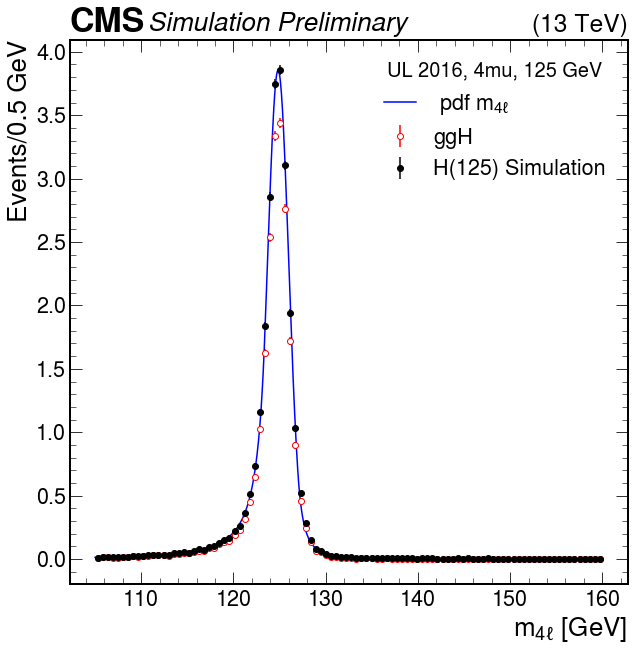

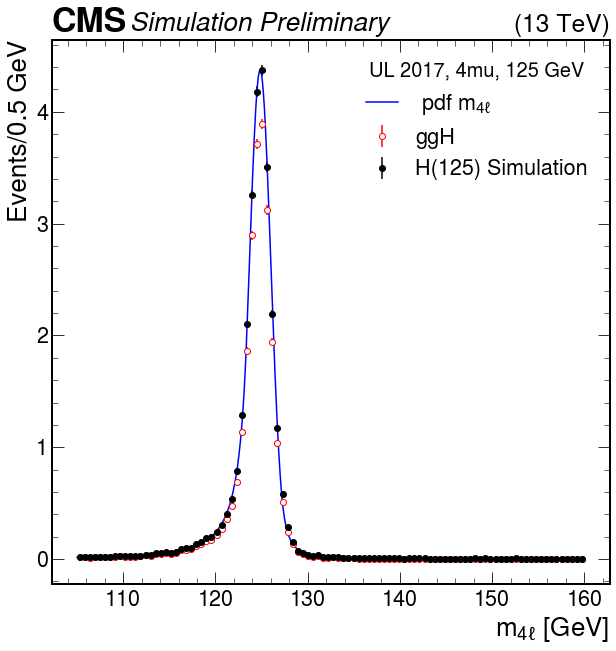

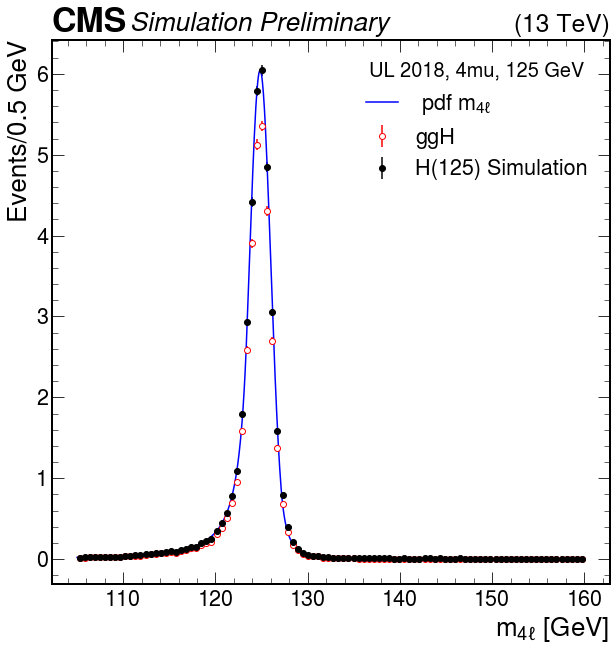

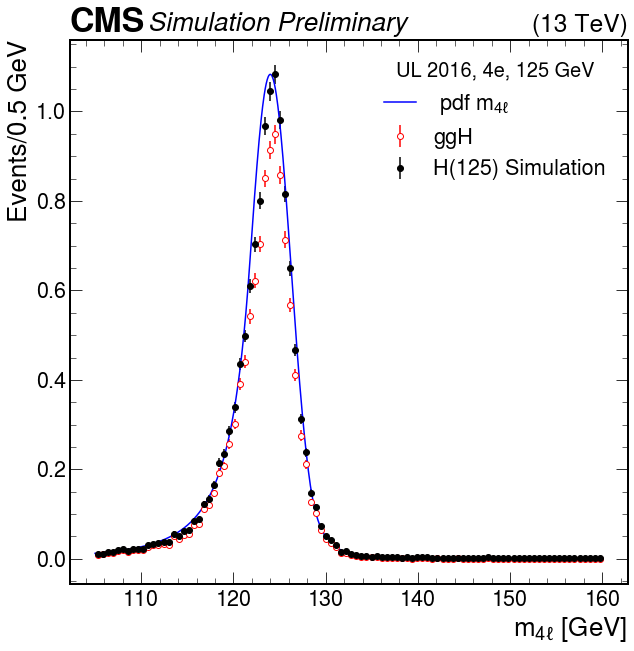

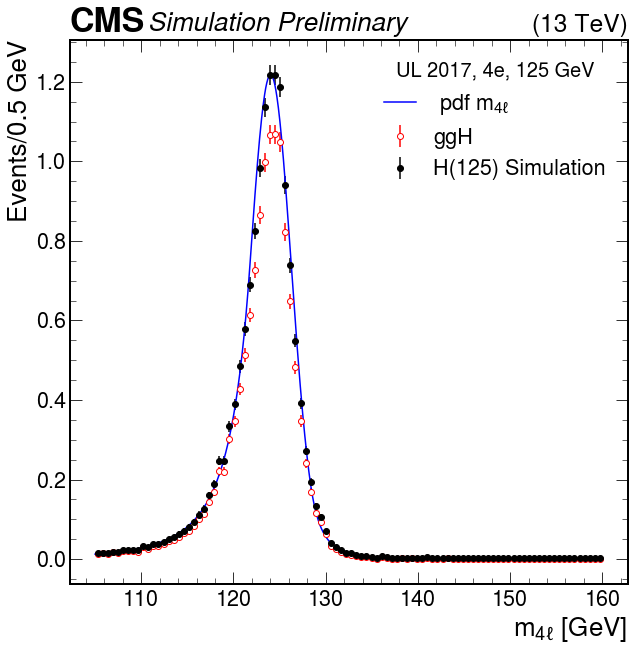

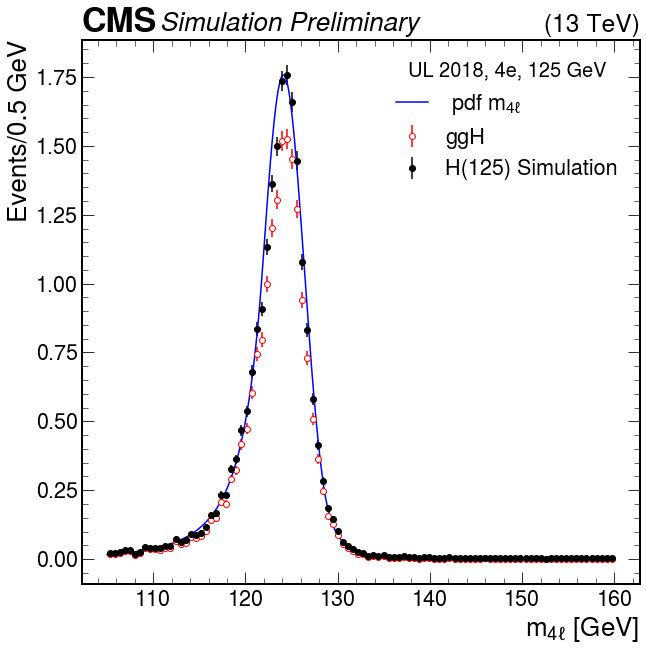

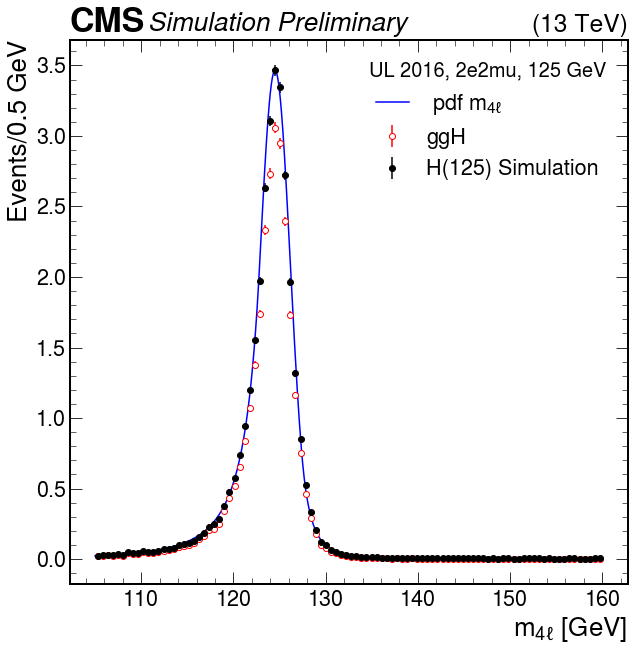

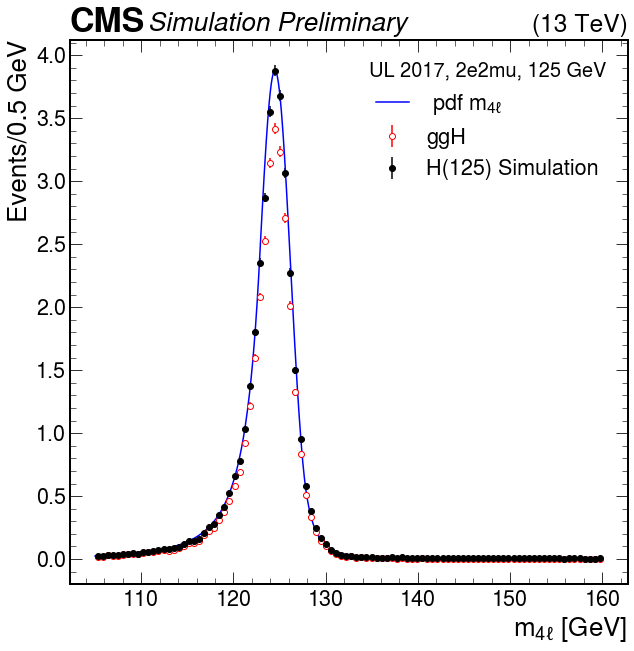

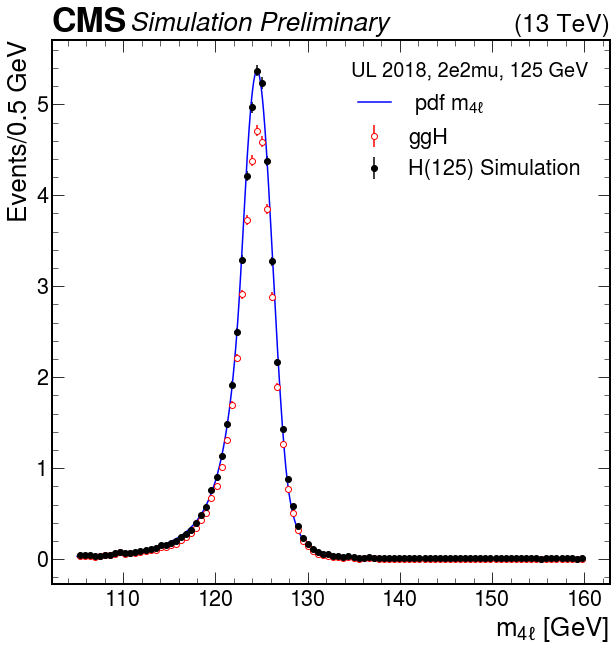

In [34]:
mH='125'
x = np.linspace(105, 140, 1000)
binning = np.linspace(105, 140, 101)
if SUFFIX!='redTree':
    x = np.linspace(105, 160, 1000)
    binning = np.linspace(105, 160, 101)

for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
    for year in [2016, 2017, 2018]:
        _name = fs; _id = idx+1

        zztot = []
        wtot = []
        ctot = []

        for pmode in ['ggH', 'VBFH', 'ttH', 'WminusH', 'WplusH', 'ZH']:
            zzmass, weight, chan = readFile(125, year, pmode = pmode, suffix=SUFFIX)
            zztot.append(zzmass)
            wtot.append(weight)
            ctot.append(chan)

        zzmass = np.concatenate(zztot)
        weight = np.concatenate(wtot)
        chan = np.concatenate(ctot)

        pmode = 'ggH'

        plt.figure()
        fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
        params = readParams(pmode, _name, year, fname = fname, mH = '125')

        zzmass_ggH, weight_ggH, chan_ggH = readFile(125, year, pmode = pmode, suffix=SUFFIX)

        n, bins = np.histogram(zzmass_ggH[chan_ggH==_id], weights=weight_ggH[chan_ggH==_id], bins = binning)
        n_err = np.sqrt(np.histogram(zzmass_ggH[chan_ggH==_id], bins=binning, weights=weight_ggH[chan_ggH==_id]**2)[0])
        n_err = n_err
        n = n
        bins = 0.5*(bins[1:]+bins[:-1])
        plt.errorbar(bins, n, yerr = n_err, color = 'r', linestyle = 'None', label ='ggH', fmt = 'o', mfc='white')

        plotPdf(pmode, zzmass, weight, chan, _id, params, year, suffix = SUFFIX, label = 'H(125) Simulation', refit = False)

        hep.cms.label(loc=0, label = 'Preliminary')
        plt.xlabel(r'$m_{4\ell}$ [GeV]')
        plt.ylabel('Events/0.5 GeV')

        plt.legend(frameon=False, title = f'UL {year}, {fs}, {mH} GeV', title_fontsize = 20)
        plt.savefig(f'{www}/ggH_Checks/ggH_pdfParam_{pmode}{mH}_{fs}_{year}.pdf',bbox_inches='tight')
        plt.savefig(f'{www}/ggH_Checks/ggH_pdfParam_{pmode}{mH}_{fs}_{year}.png',bbox_inches='tight')

# Main plotter: p.d.f. per production mechanism and final state

Here we plot the p.d.f. obtained from the simultaneous fit over the `5` mass points ($m_H=120,124,125,126,130$ GeV) for all the production mechanisms, data taking periods, and final states.

In the case of the associated productions, the double sided crystall ball is supplemented with an additional landau contribution, also displayed in the plots.

The plots produced here are actually obtained refitting the signals with the same p.d.f. used in the analysis, starting from the input parameters obtained from the simultaneous fit.

Eventually, this refitted function may result in a slightly better description of the signal lineshape and could be used in the analysis. However, the p.d.f. obtained from the simultaneous fit gives an optimal description already.

/tmp/ipykernel_1005/736064121.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6005: RuntimeWarning: overflow encountered in exp
  return np.exp(-0.5 * (x + np.exp(-x))) / np.sqrt(2*np.pi)
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could no

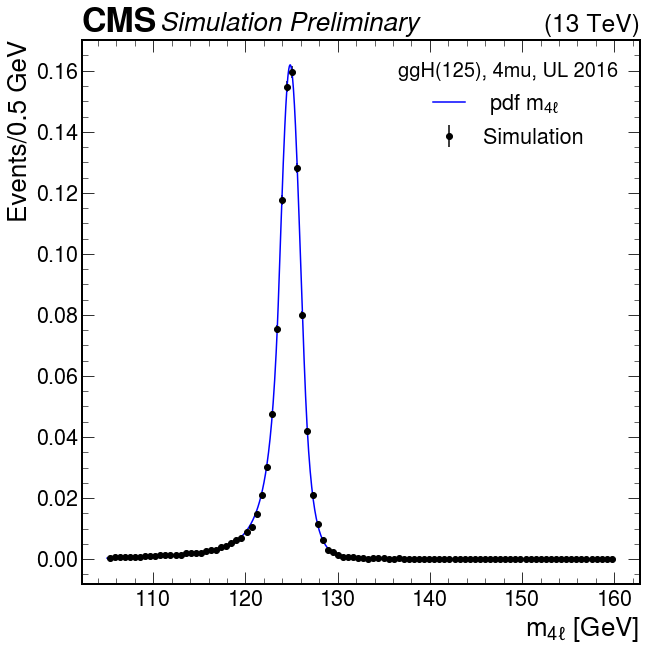

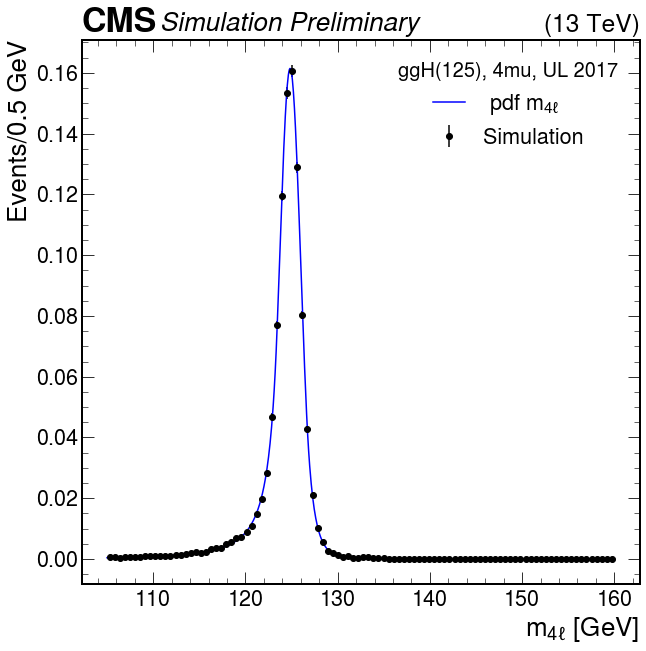

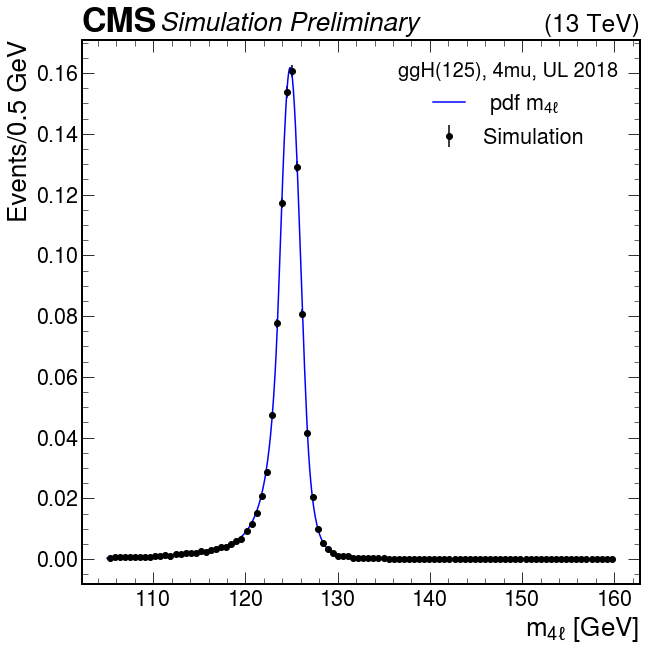

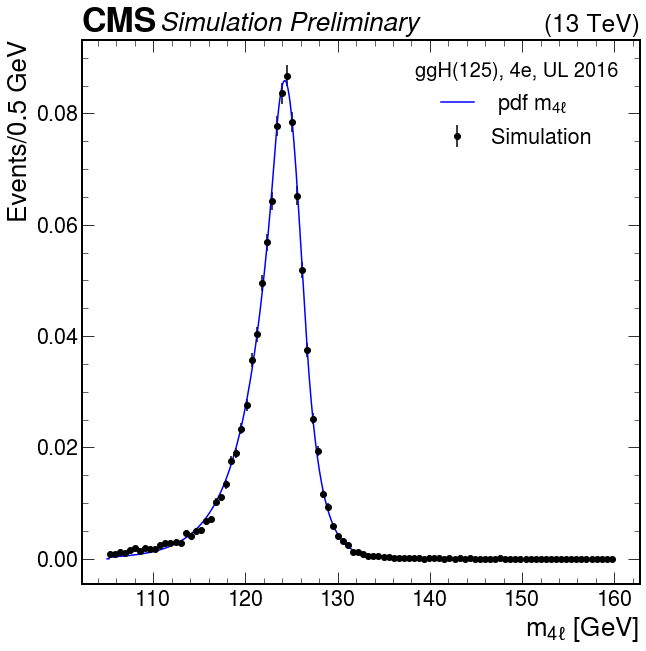

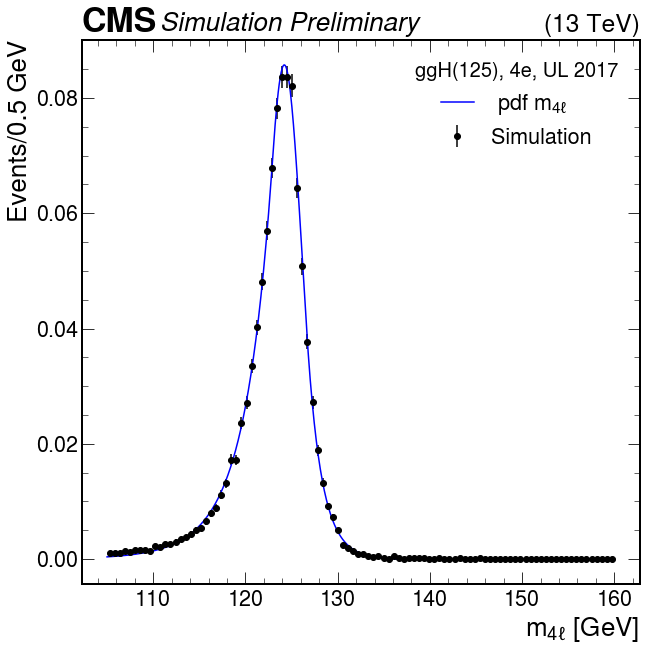

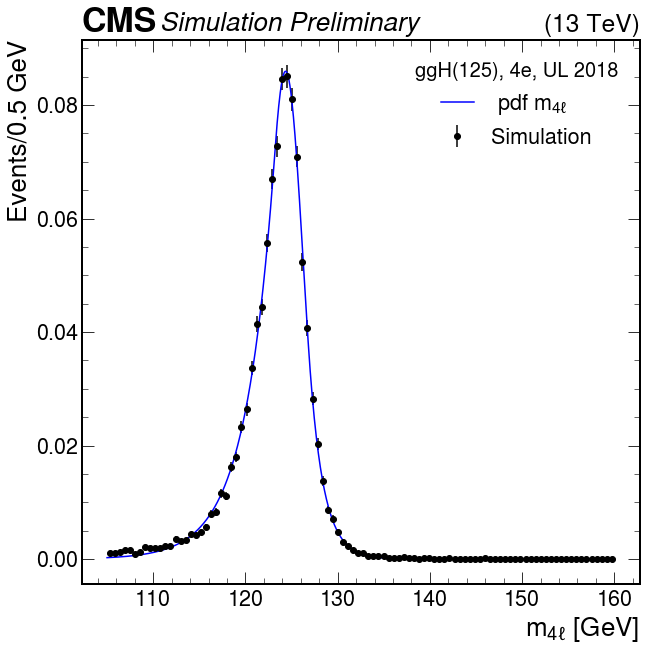

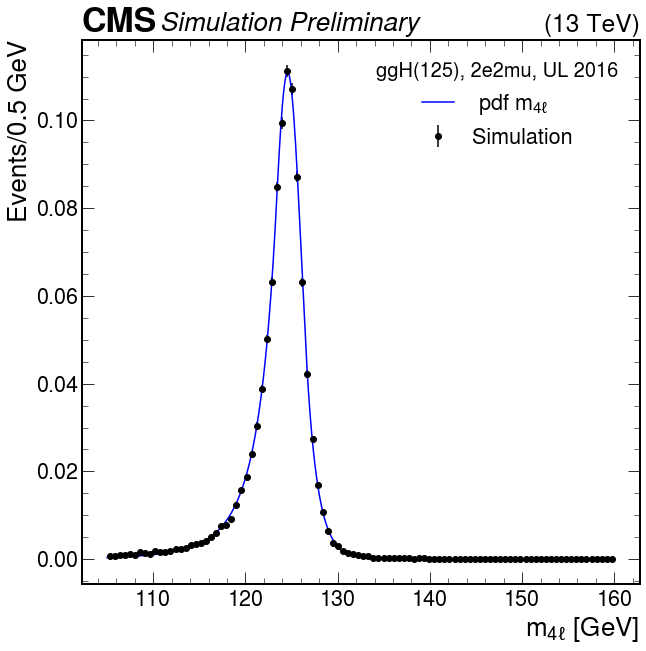

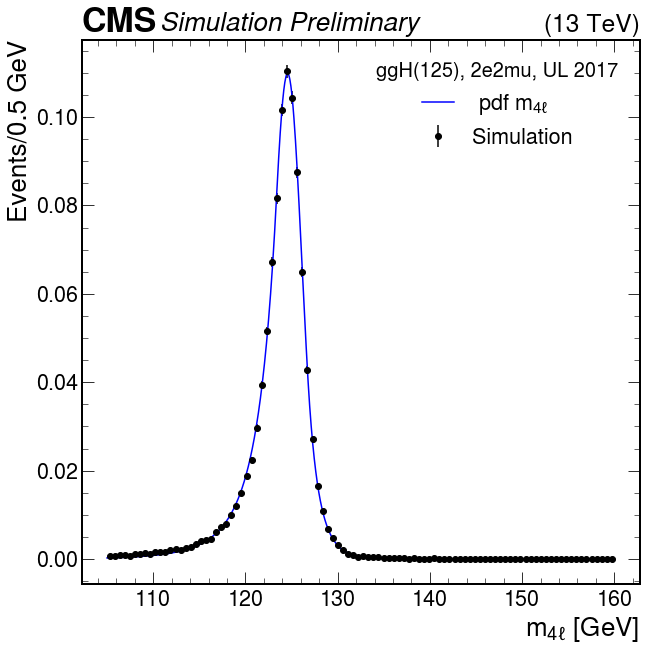

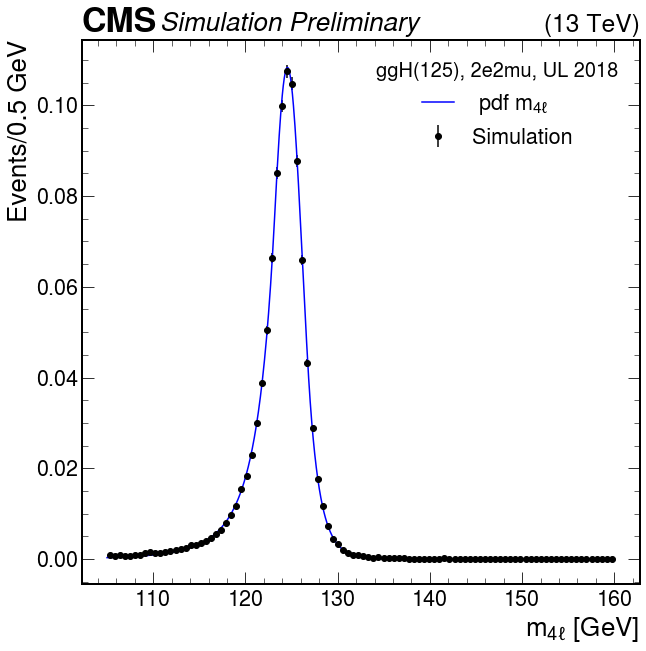

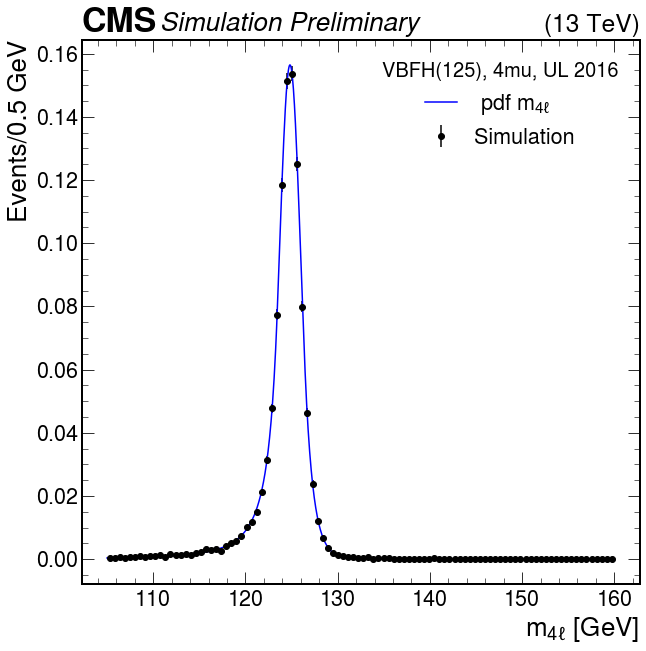

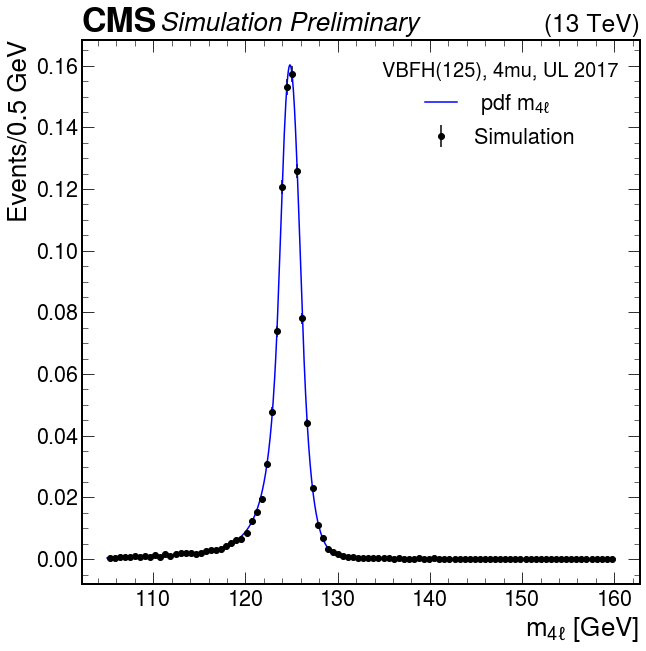

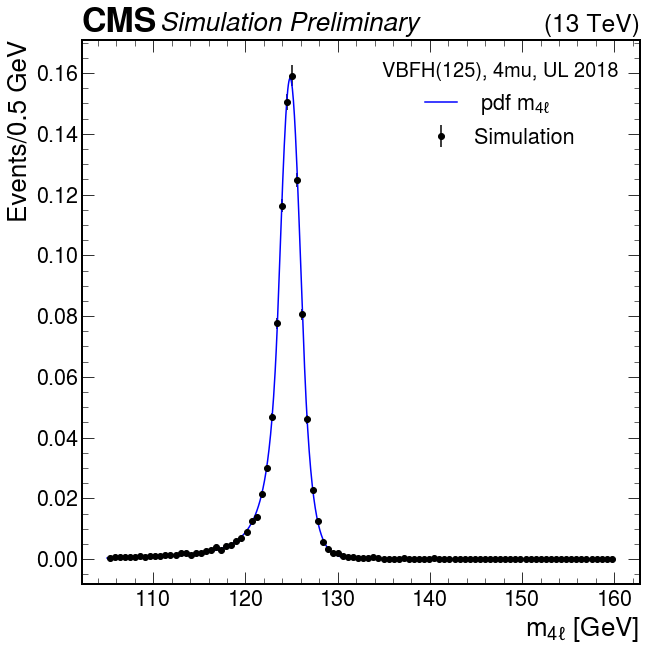

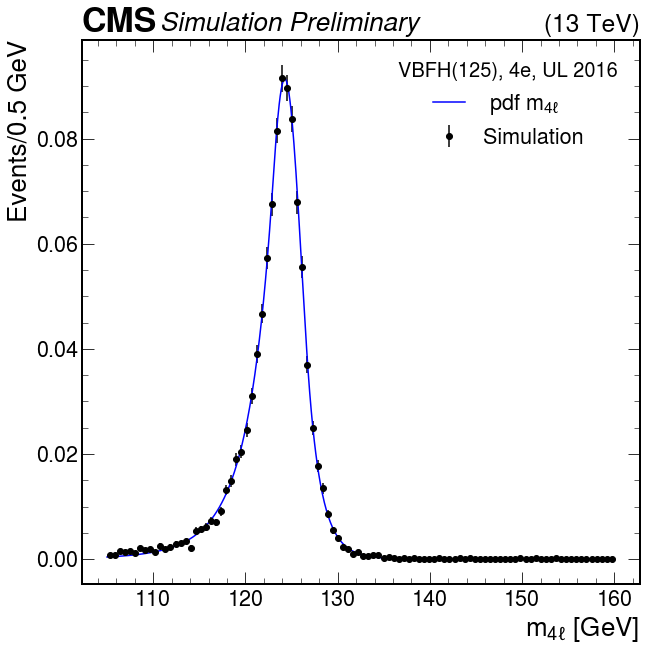

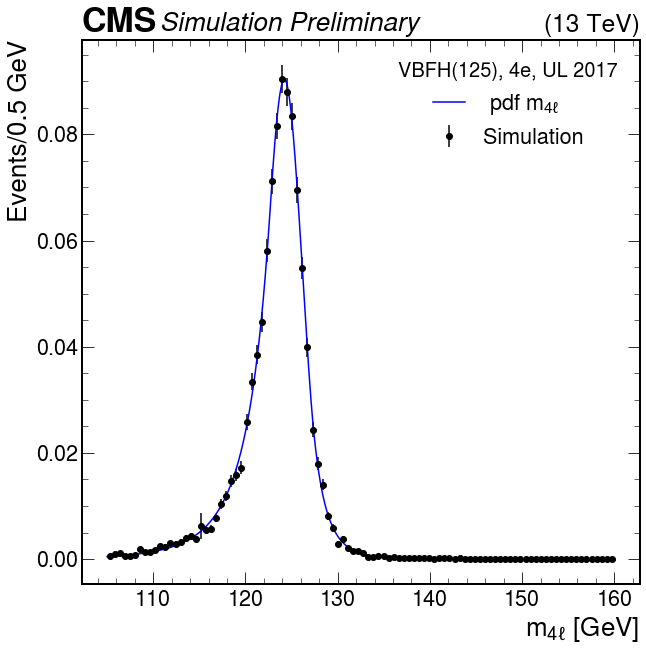

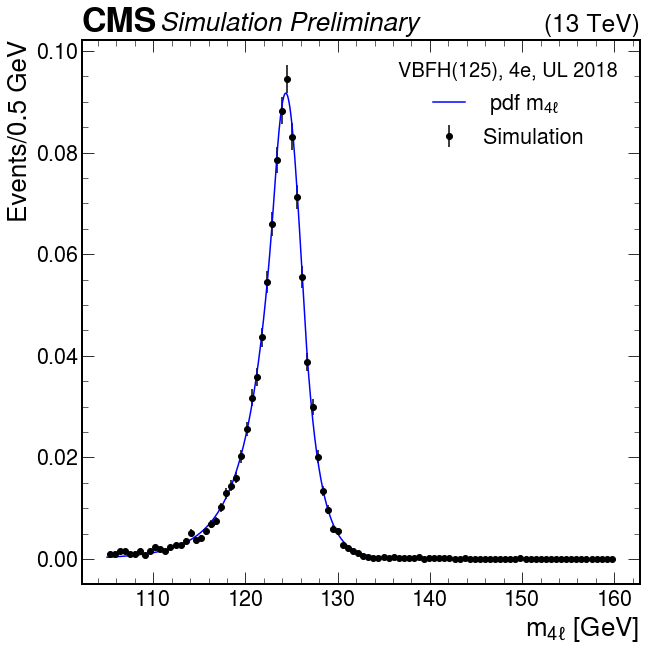

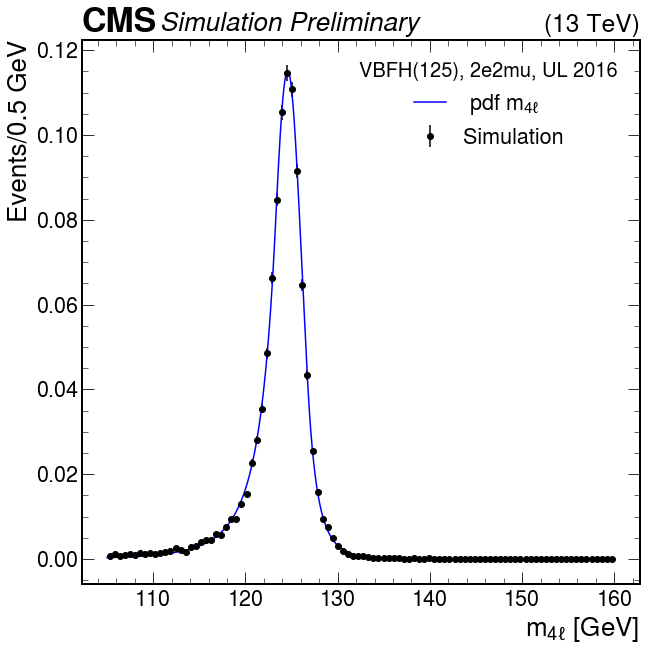

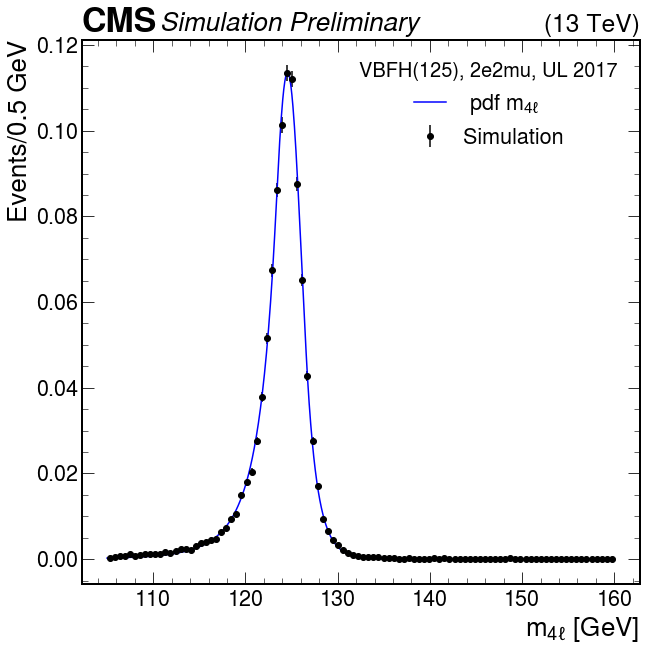

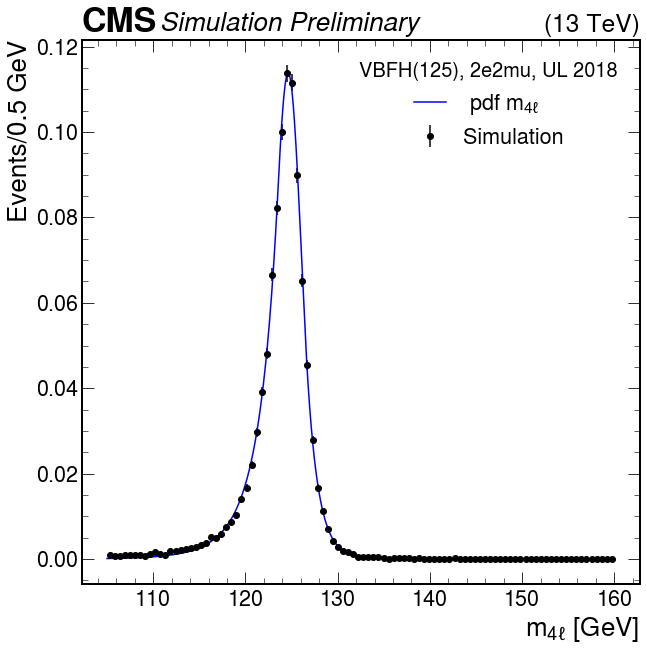

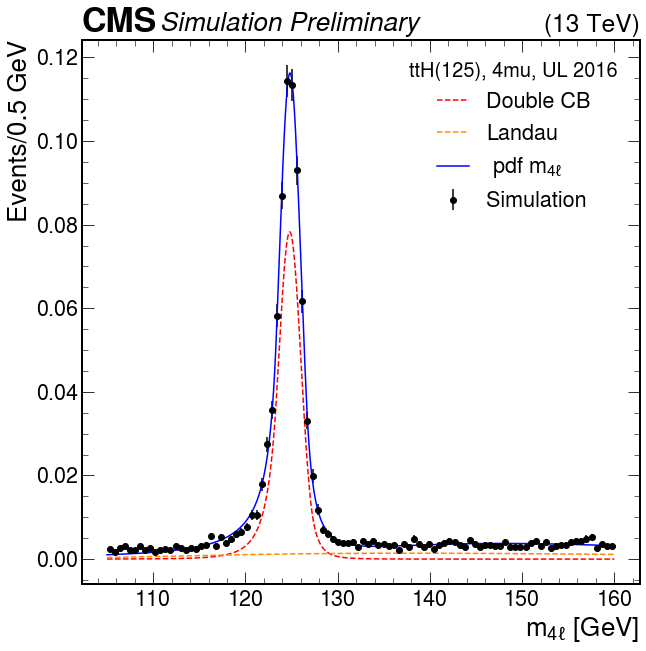

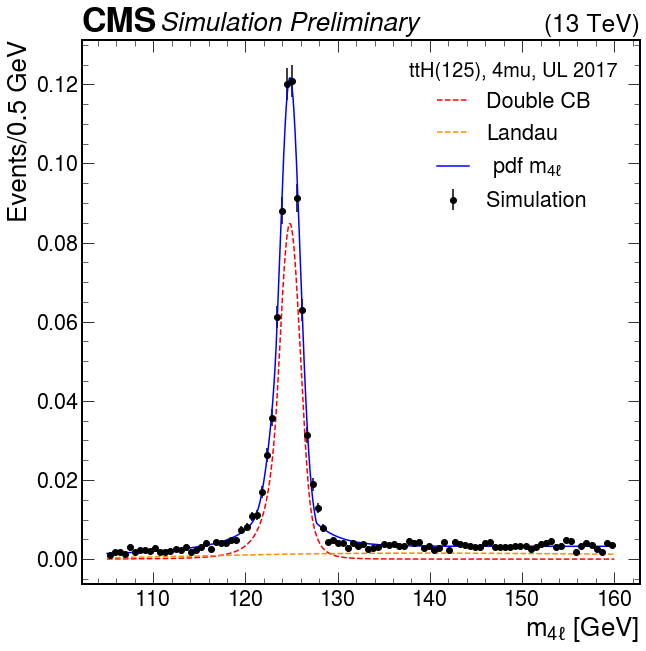

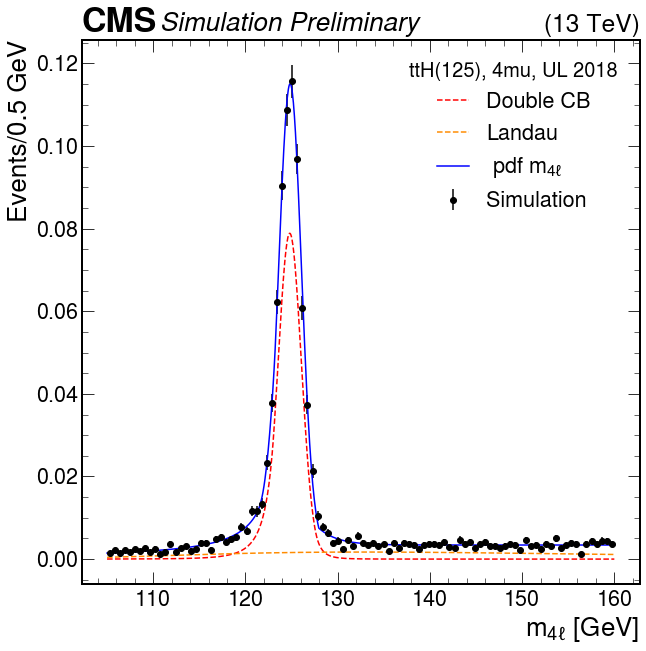

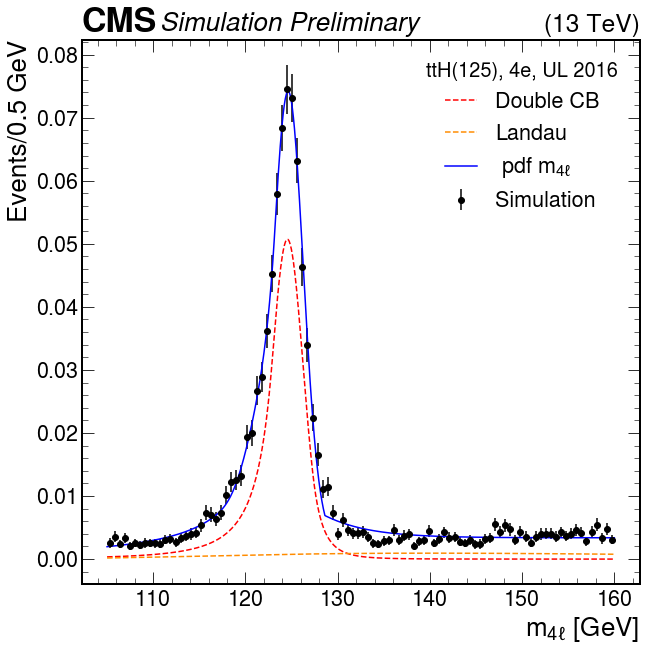

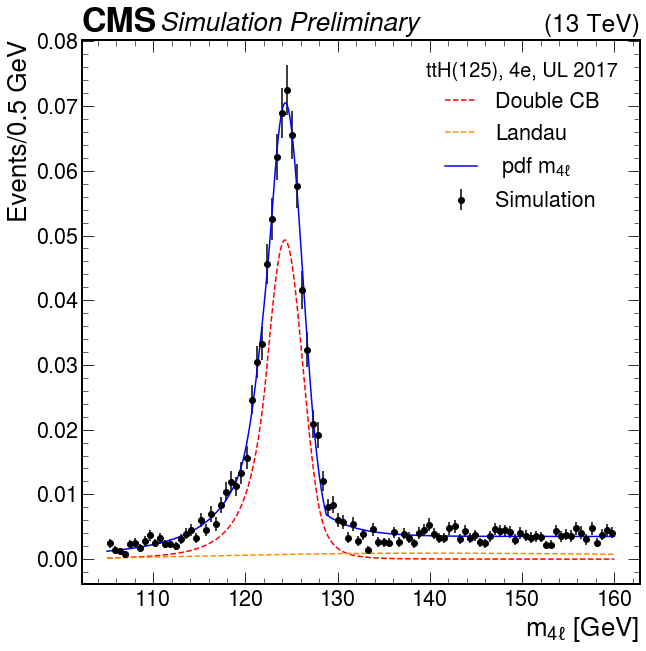

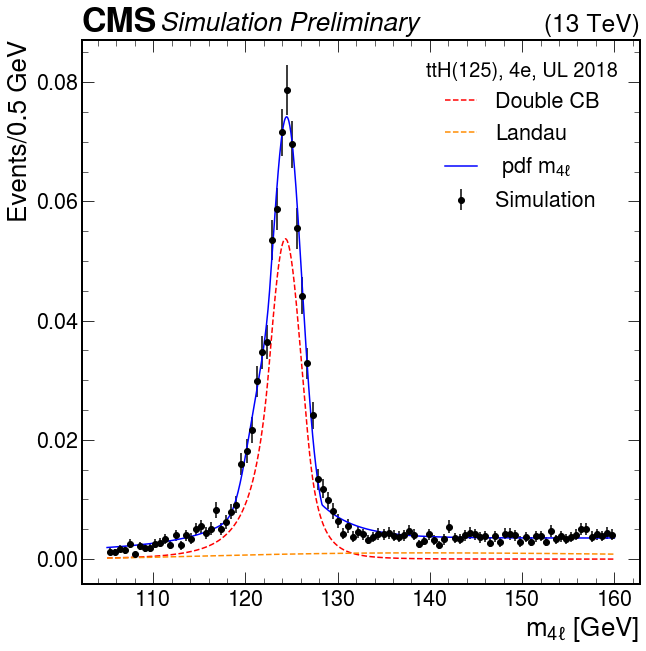

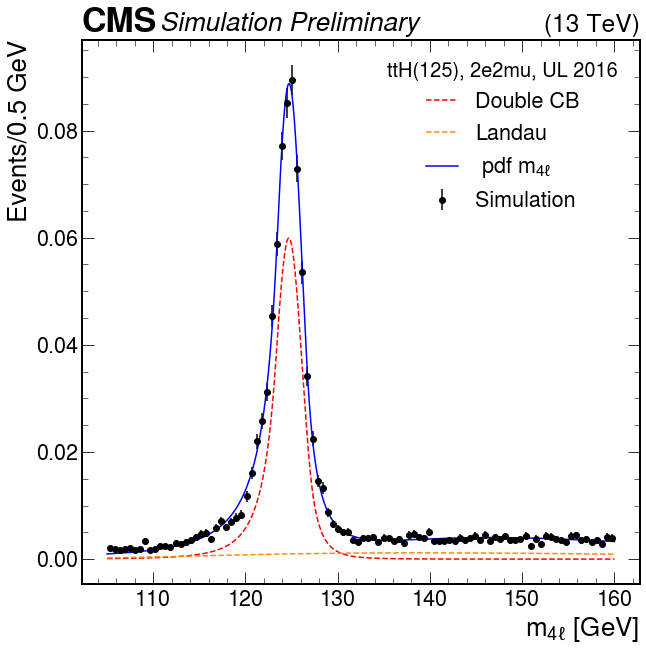

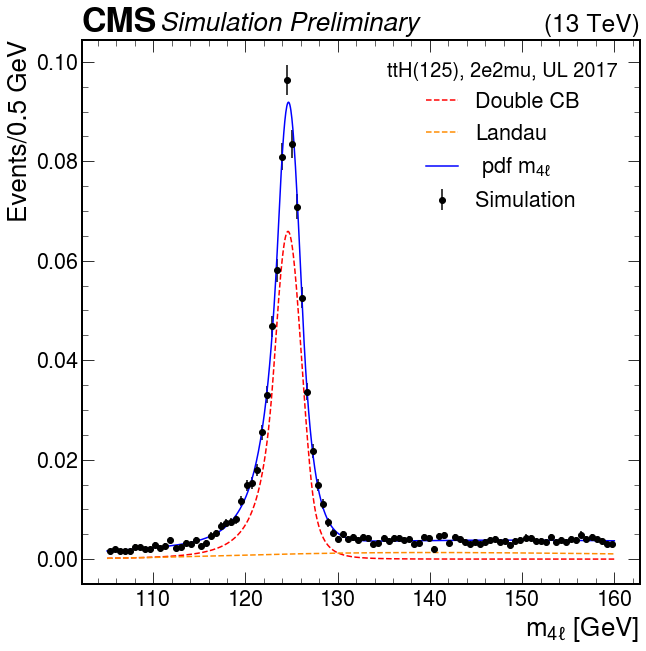

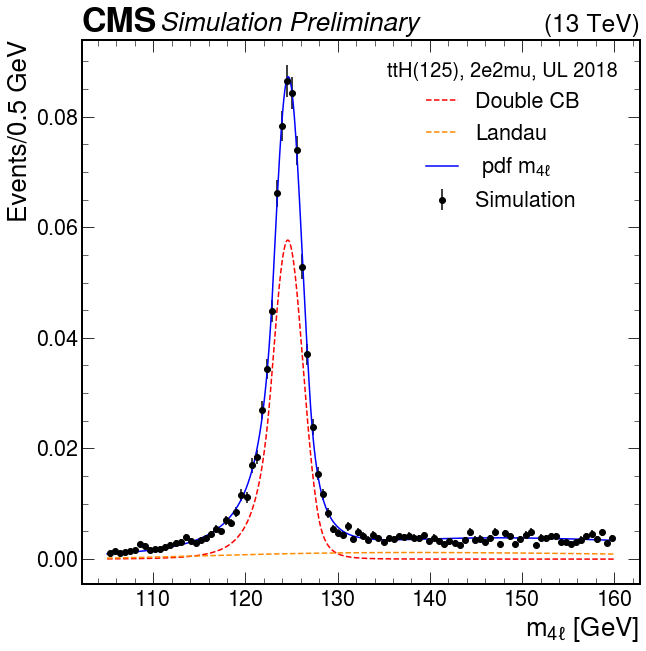

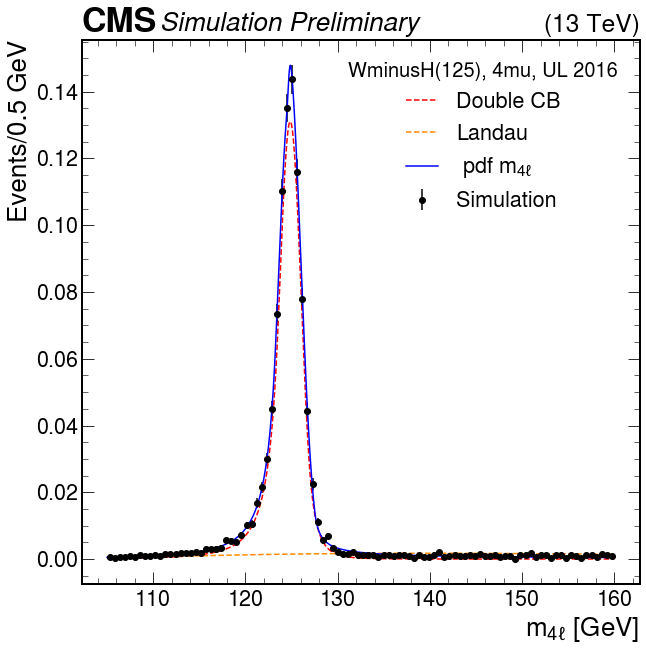

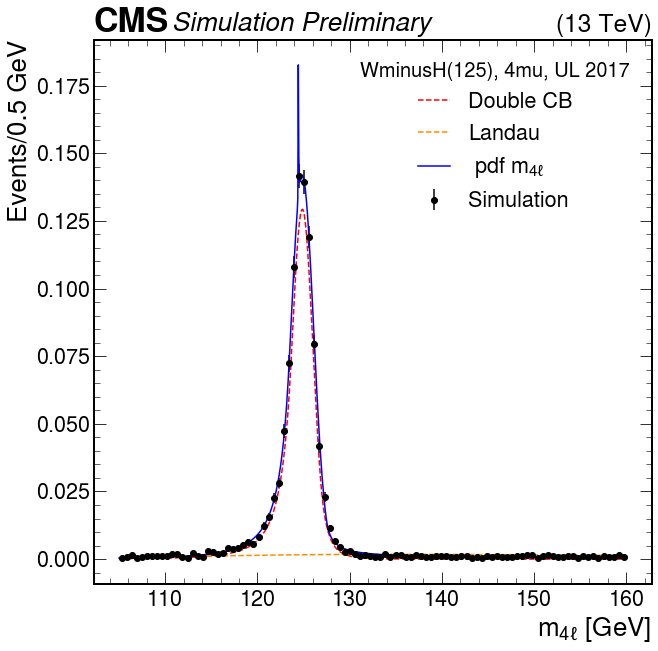

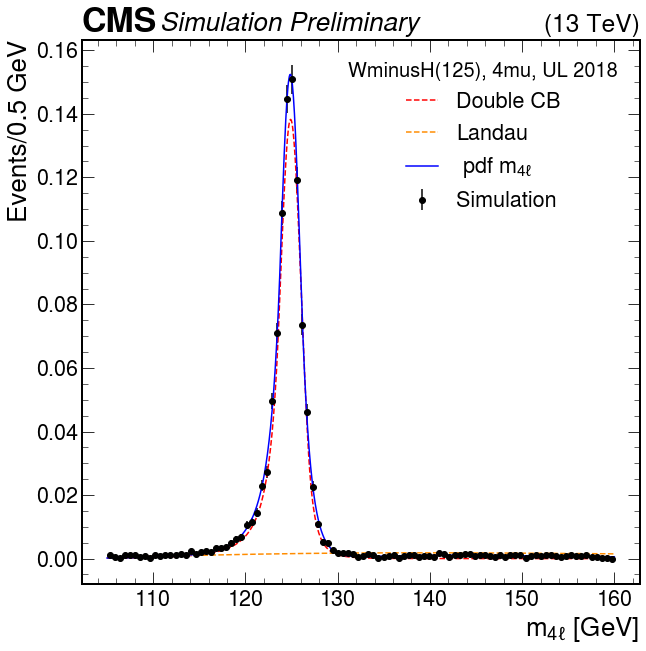

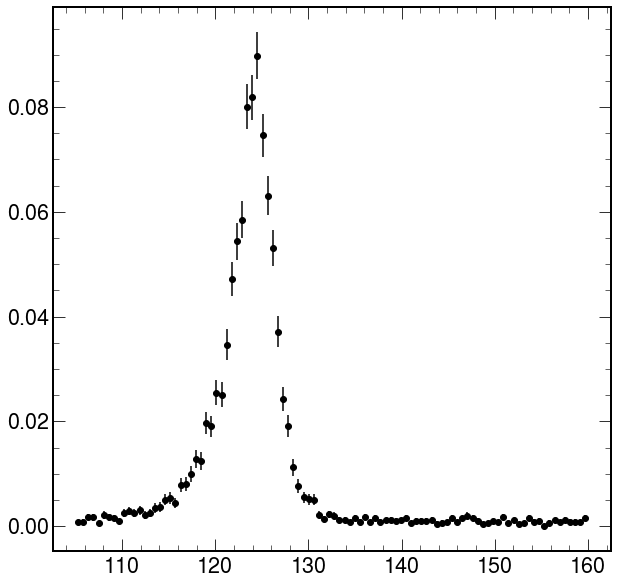

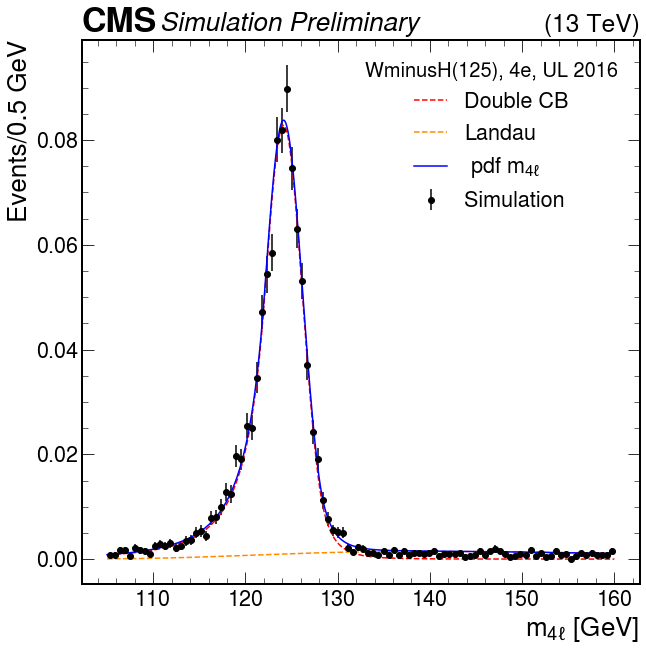

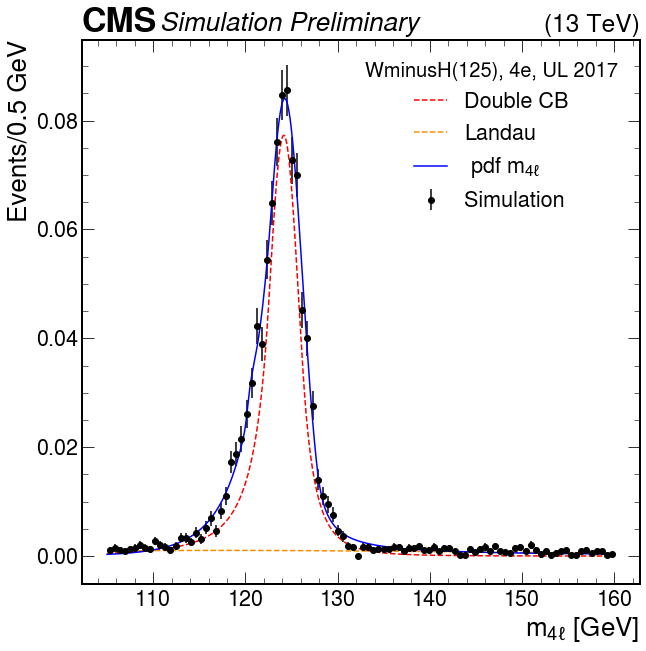

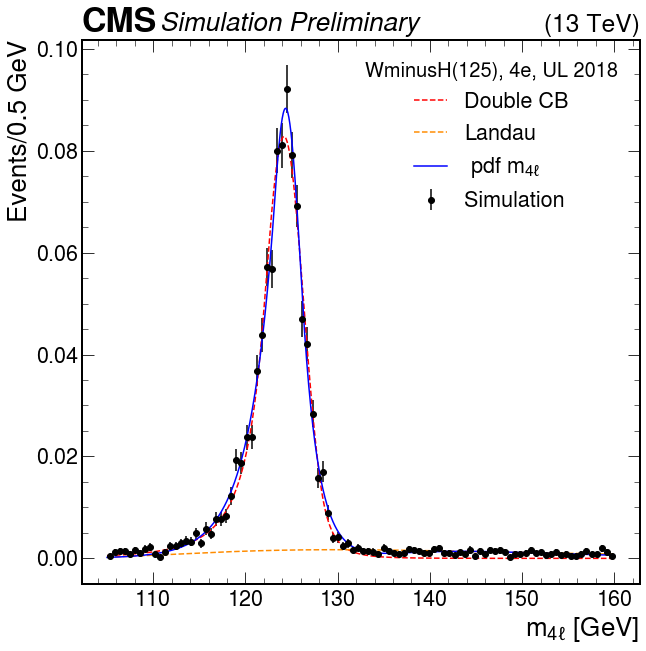

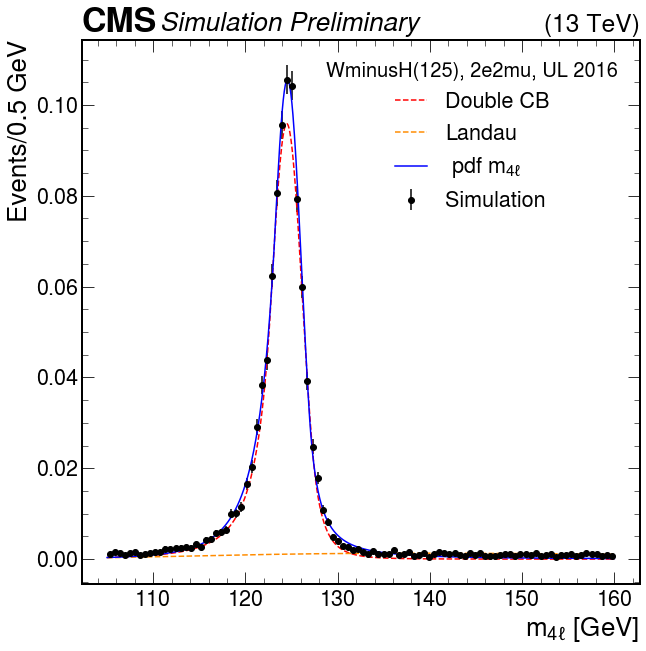

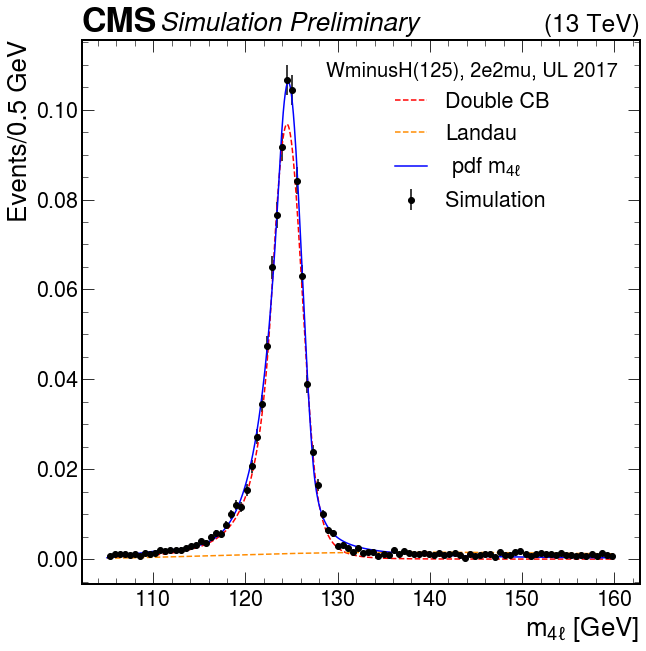

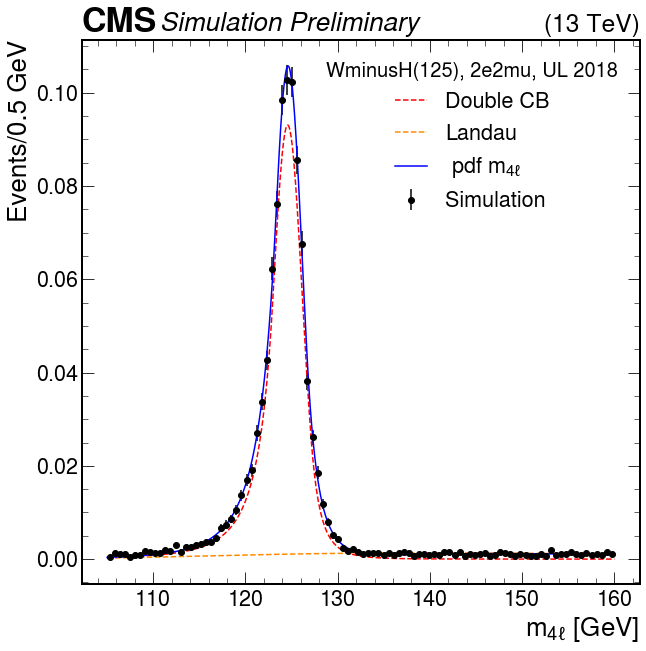

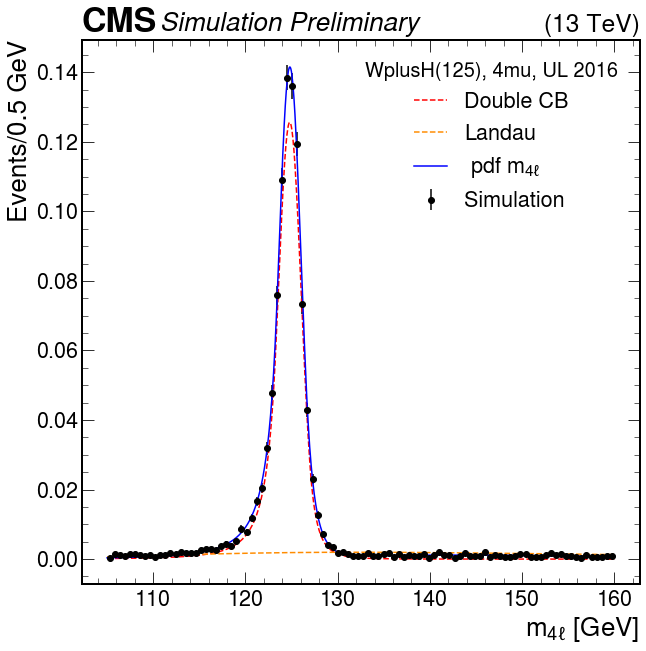

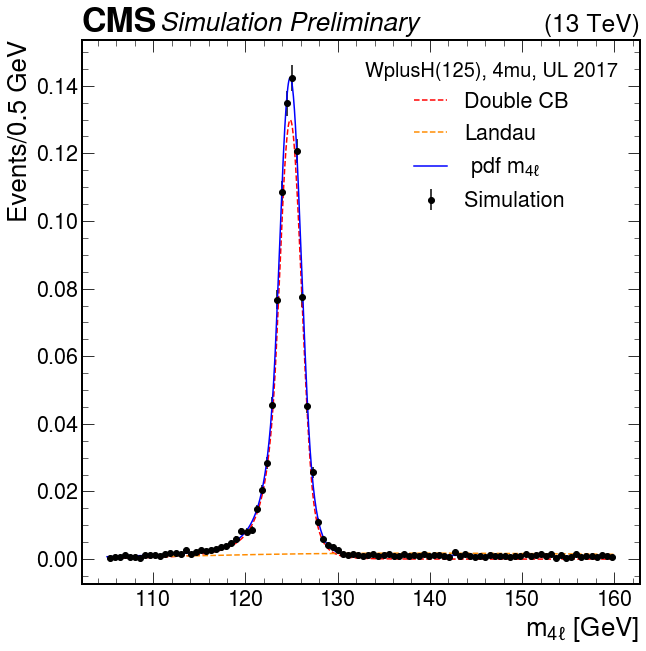

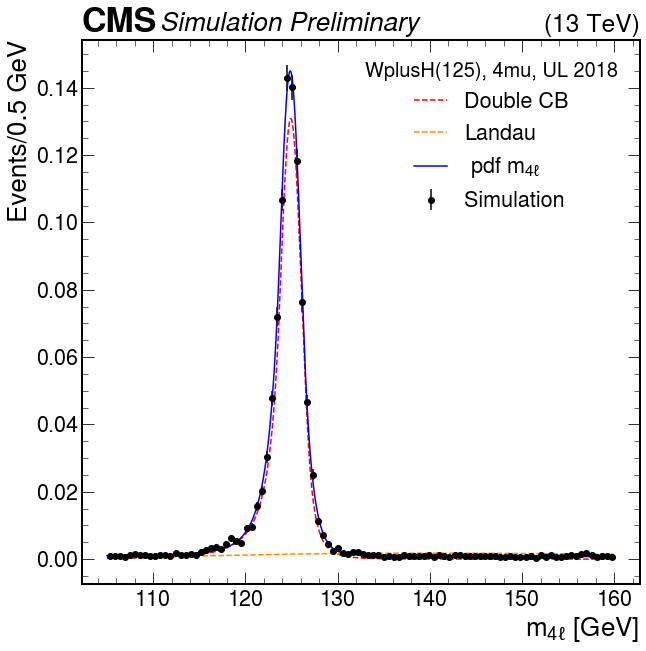

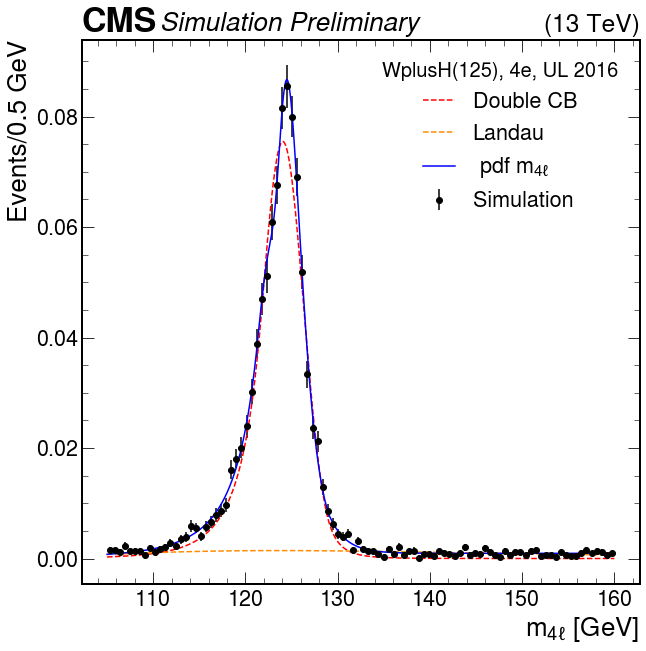

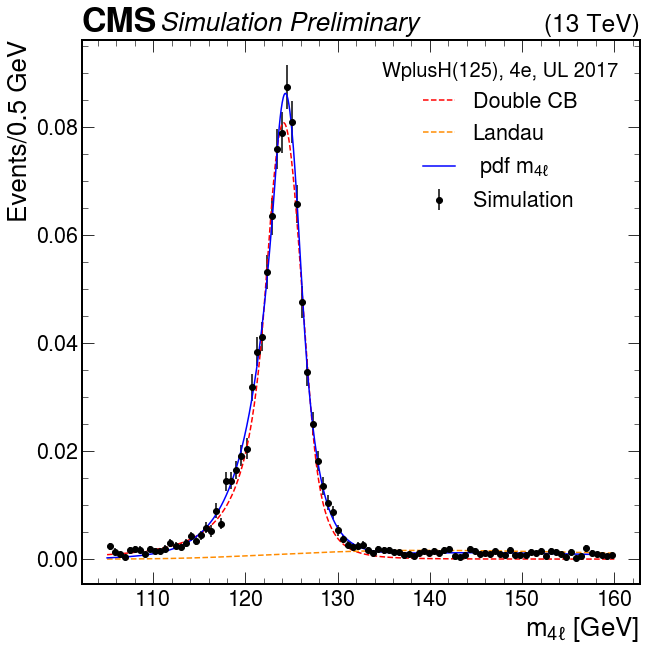

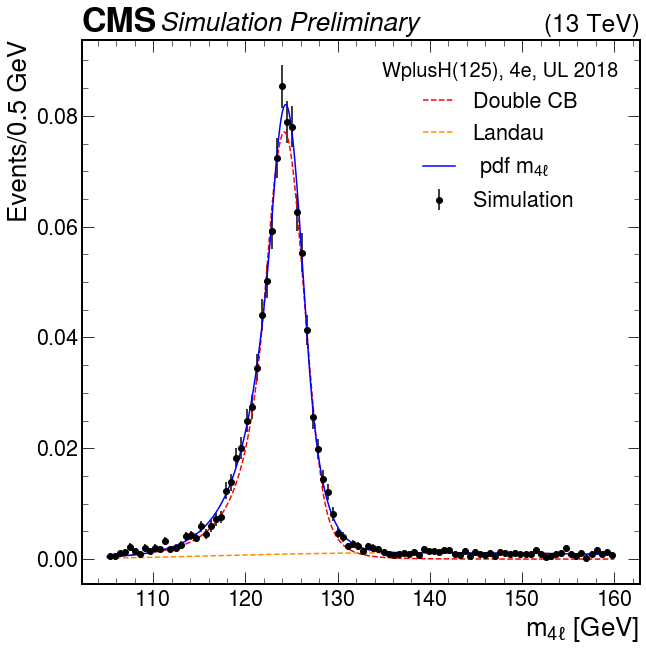

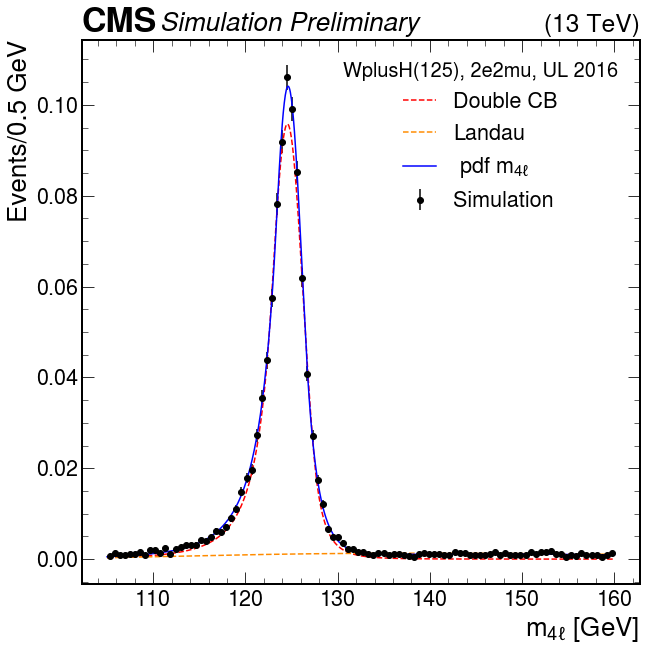

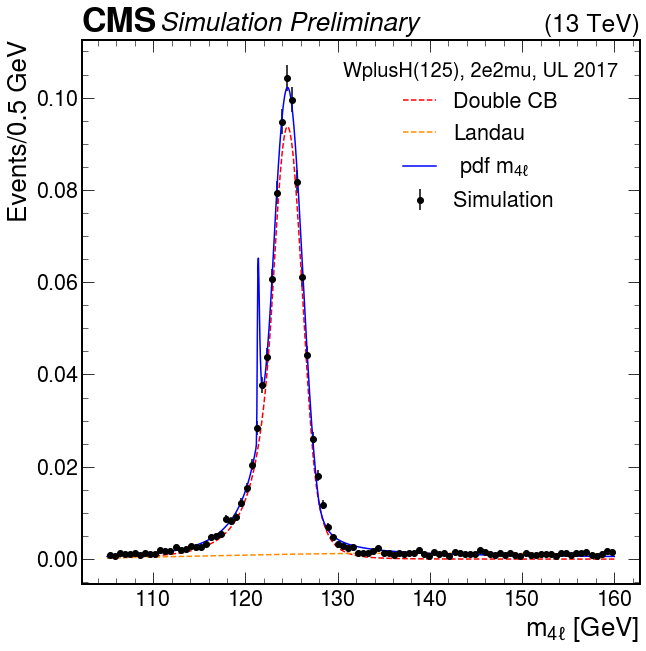

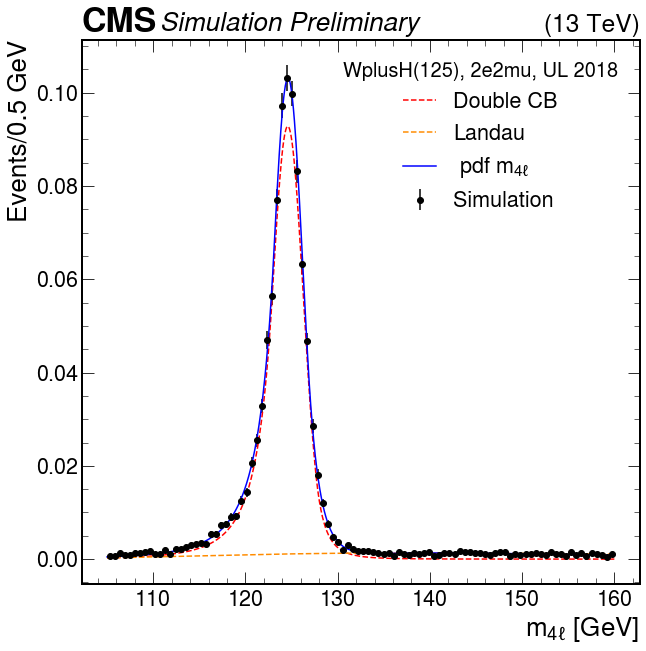

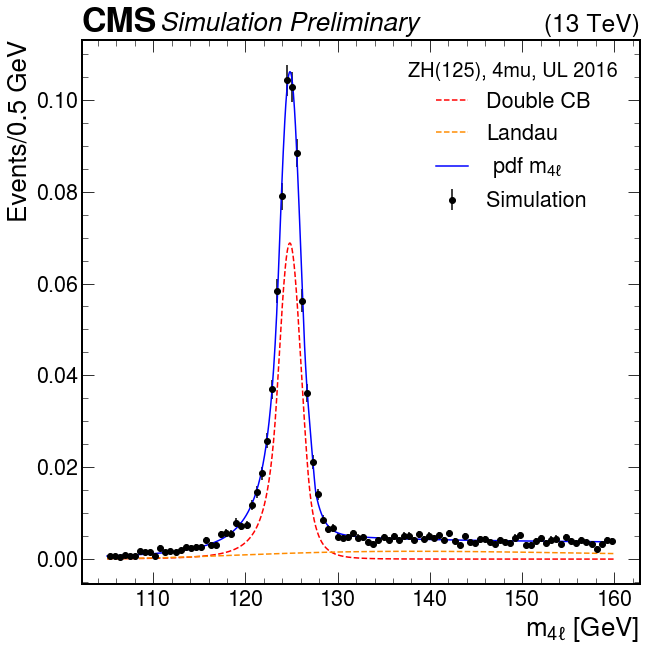

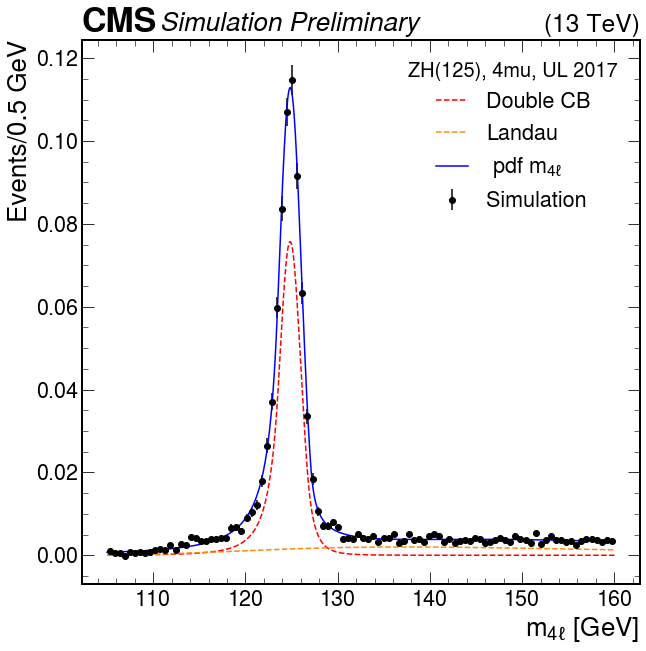

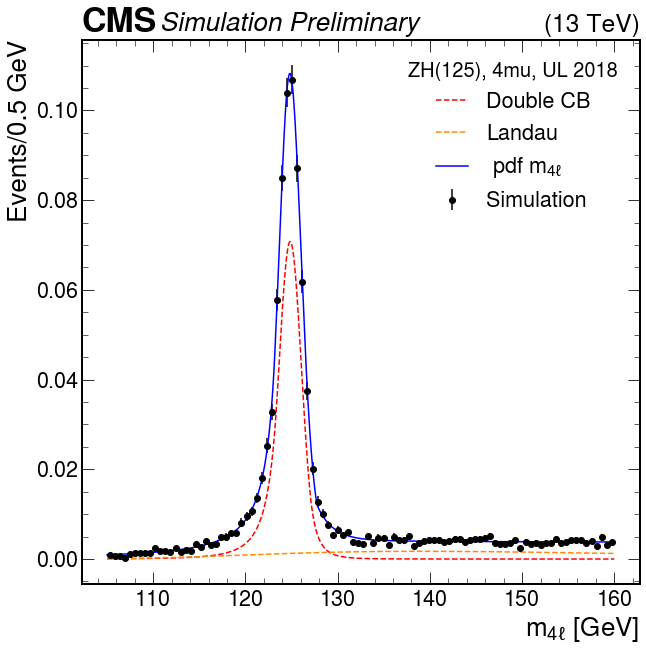

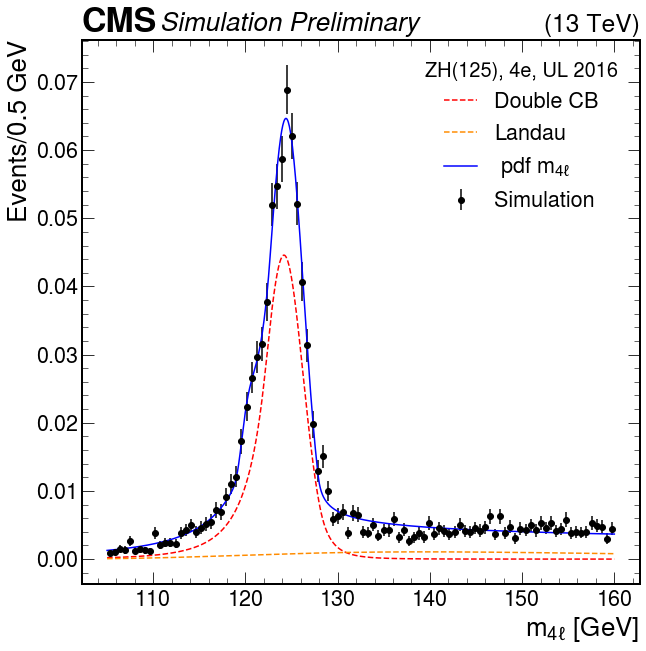

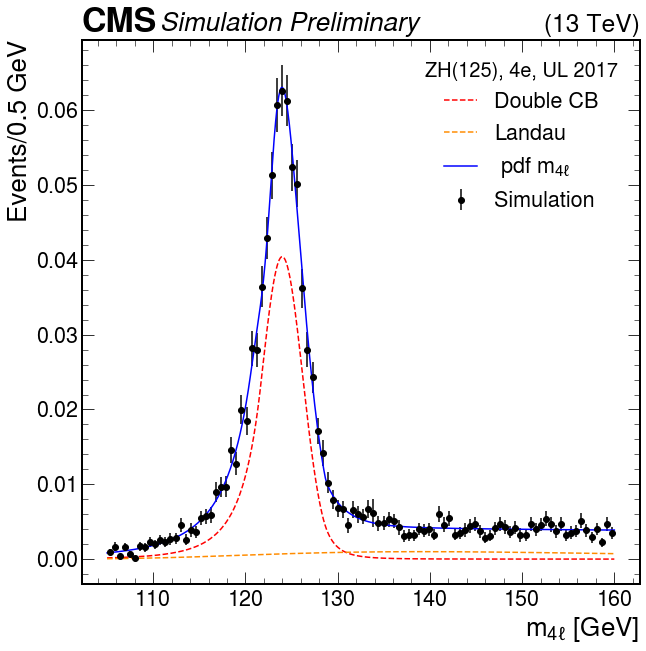

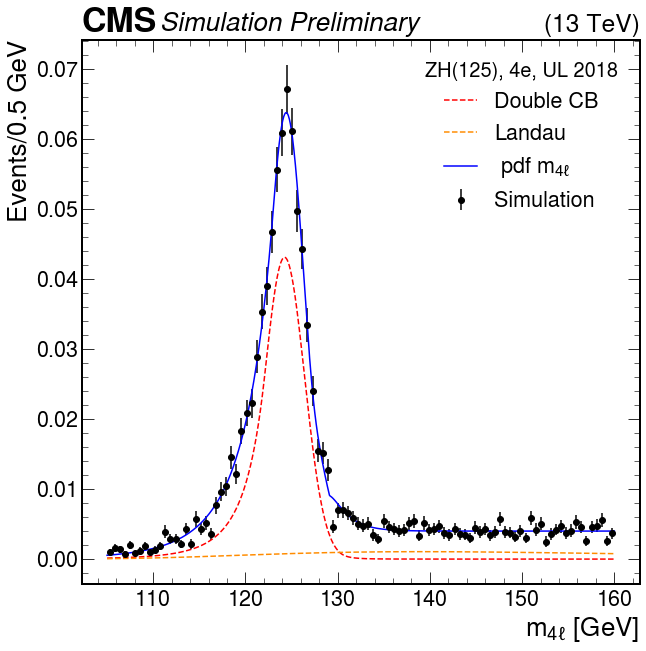

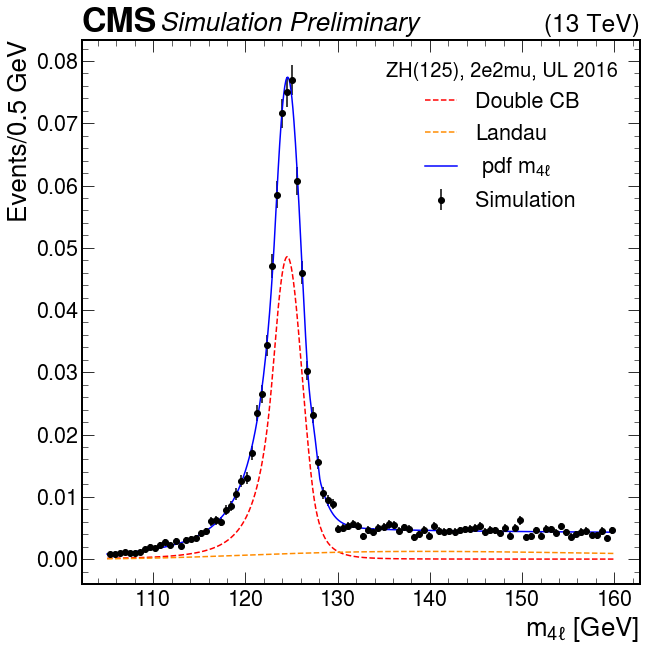

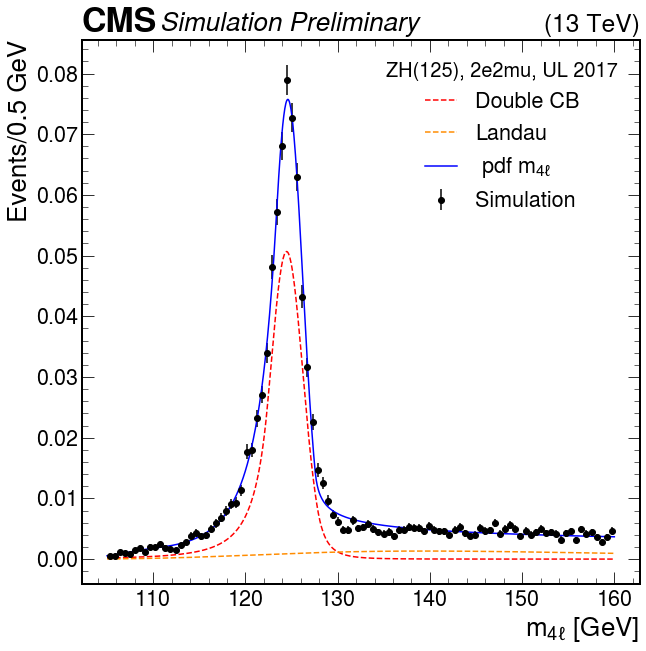

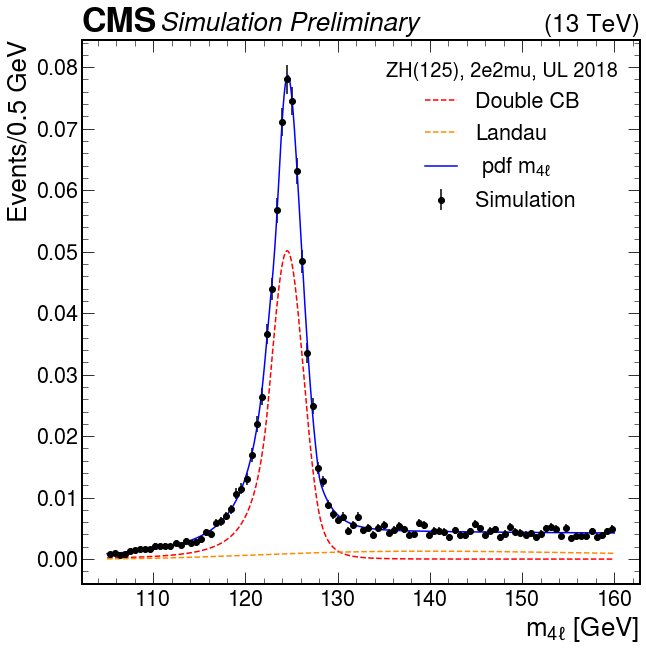

In [26]:
www = f'/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/param/{WWW_DEST}'
mH='125'
for pmode in ['ggH', 'VBFH', 'ttH', 'WminusH', 'WplusH', 'ZH']:
#     for mH in ['125']:#'120', '124', '125', '126', '130']:
    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        for year in [2016, 2017, 2018]:
            try:
                _name = fs; _id = idx+1

                x = np.linspace(105, 140, 1000)
                if SUFFIX!='redTree':
                    x = np.linspace(105, 160, 1000)

                zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)
                plt.figure()
                fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
                os.system(f'cp {fname} {www}/fitParams')
                params = readParams(pmode, _name, year, fname = fname, mH=mH)
                plotPdf(pmode, zzmass, weight, chan, _id, params, year, suffix=SUFFIX, refit = True, www = f'{www}/fitParams/refit', dumpToTxt=True)

                hep.cms.label(loc=0, label = 'Preliminary')
                plt.xlabel(r'$m_{4\ell}$ [GeV]')
                plt.ylabel('Events/0.5 GeV')
                plt.legend(frameon=False, title = f'{pmode}({mH}), {fs}, UL {year}', title_fontsize = 20)

                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}.pdf',bbox_inches='tight')
                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}.png',bbox_inches='tight')
            except RuntimeError:
                _name = fs; _id = idx+1

                x = np.linspace(105, 140, 1000)
                if SUFFIX!='redTree':
                    x = np.linspace(105, 160, 1000)

                zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)
                plt.figure()
                fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
                os.system(f'cp {fname} {www}/fitParams')
                params = readParams(pmode, _name, year, fname = fname, mH=mH)
                plotPdf(pmode, zzmass, weight, chan, _id, params, year, suffix=SUFFIX, refit = False)

                hep.cms.label(loc=0, label = 'Preliminary')
                plt.xlabel(r'$m_{4\ell}$ [GeV]')
                plt.ylabel('Events/0.5 GeV')
                plt.legend(frameon=False, title = f'{pmode}({mH}), {fs}, UL {year}', title_fontsize = 20)

                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}.pdf',bbox_inches='tight')
                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}.png',bbox_inches='tight')

# Quick check of a single pdf and production mode

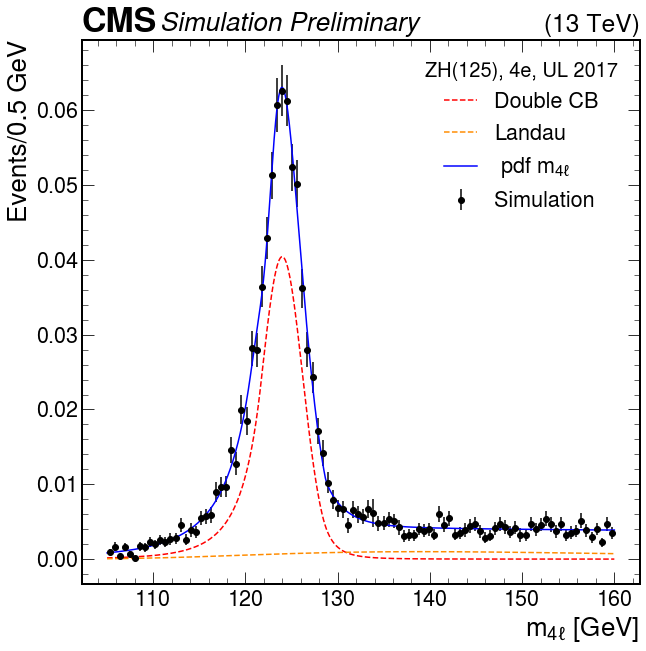

In [27]:
mH='125'
pmode = 'ZH'
idx = 2
fs = '4e'
year = 2017
_name = fs; _id = idx

x = np.linspace(105, 140, 1000)
if SUFFIX!='redTree':
    x = np.linspace(105, 160, 1000)

zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)
plt.figure()
fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
params = readParams(pmode, _name, year, fname = fname, mH=mH)
plotPdf(pmode, zzmass, weight, chan, _id, params, year, suffix=SUFFIX)

hep.cms.label(loc=0, label = 'Preliminary')
plt.xlabel(r'$m_{4\ell}$ [GeV]')
plt.ylabel('Events/0.5 GeV')
plt.legend(frameon=False, title = f'{pmode}({mH}), {fs}, UL {year}', title_fontsize = 20)

# Obtaining the final p.d.f. for the analysis

As mentioned above, in the analysis we use the p.d.f. obtained from the fit of the `ggH` reconstructed $m_{4\ell}$ for the four-lepton resonance.

The additional contribution from the Landau is estimated here, starting from the Landau parametrizations of the $VH$ and $t\bar{t}H$ production modes.

More precisely, the mean of the MPV and sigma of these Landaus enter the analysis to model these missing leptons contributions.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


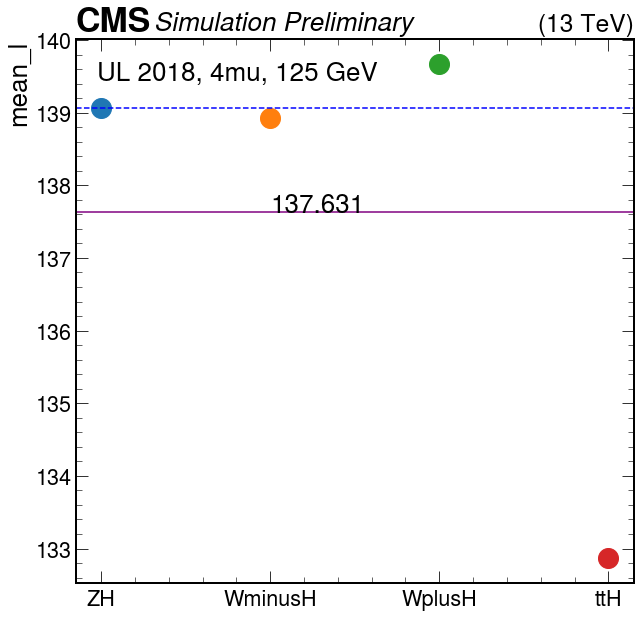

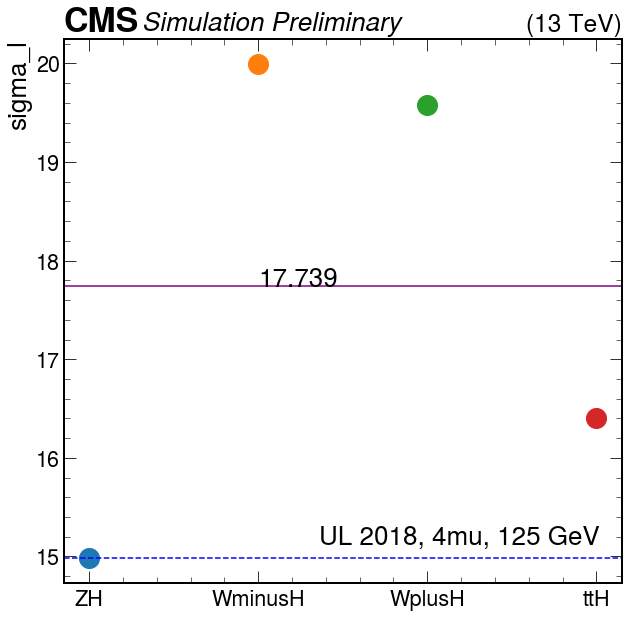

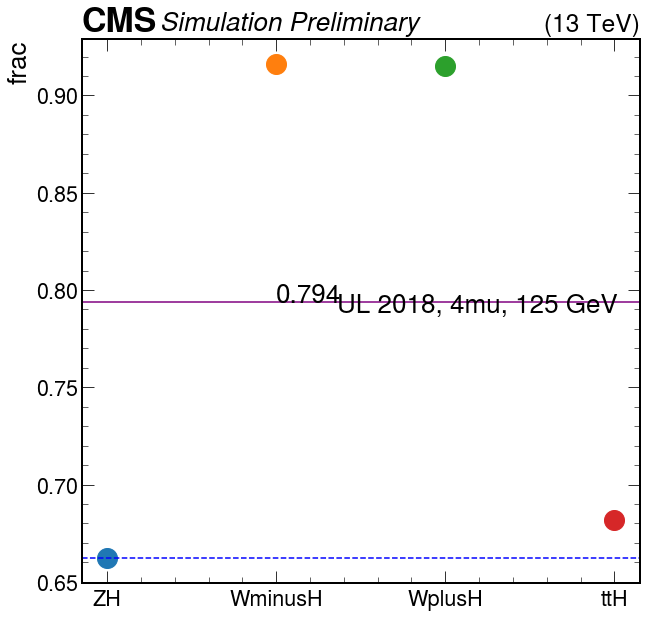

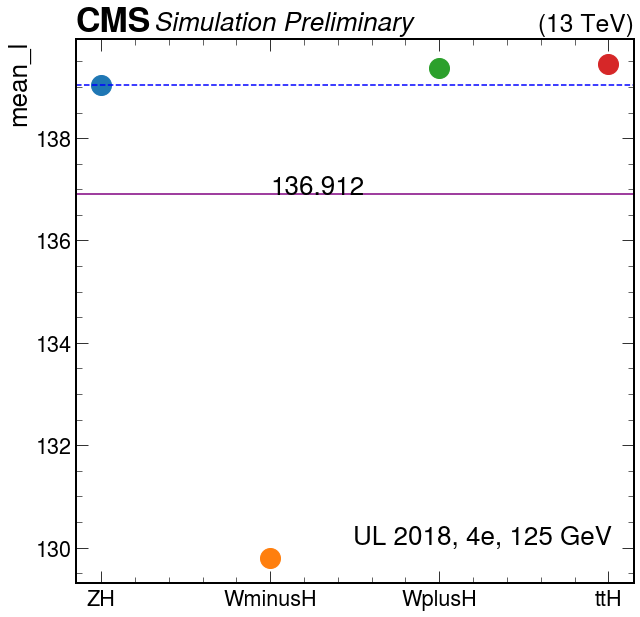

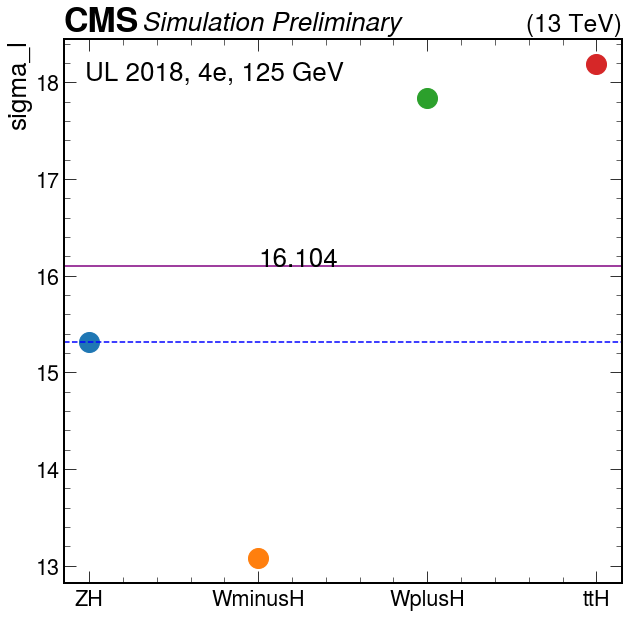

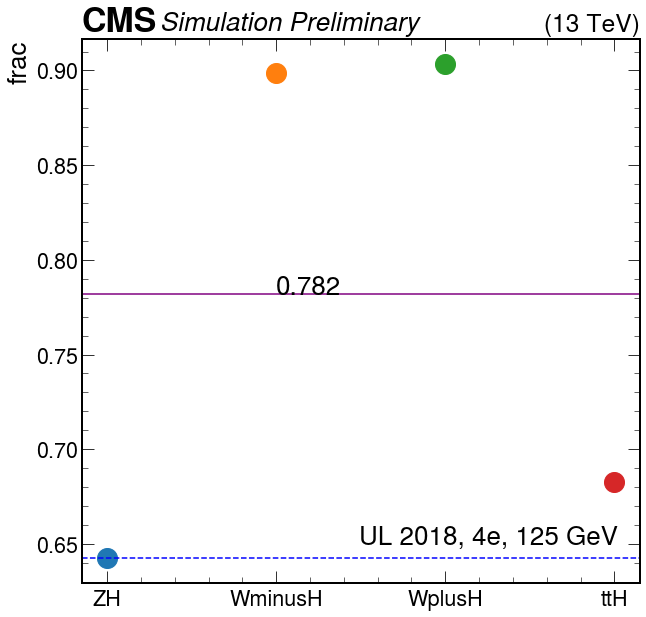

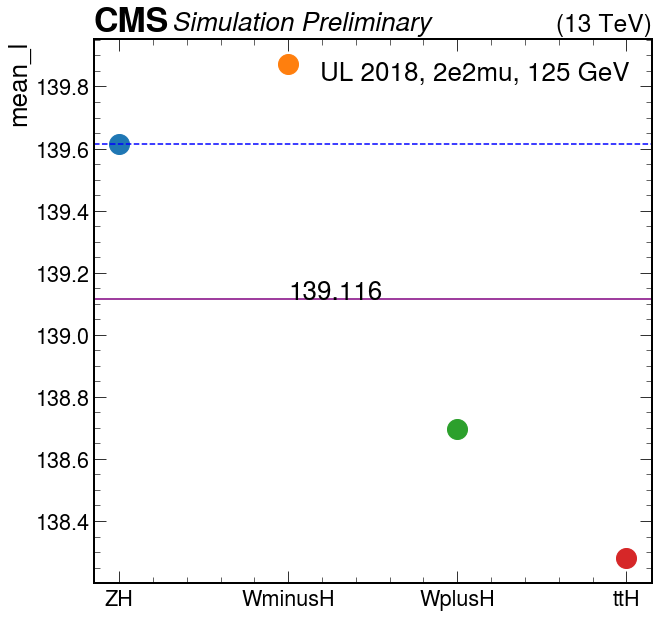

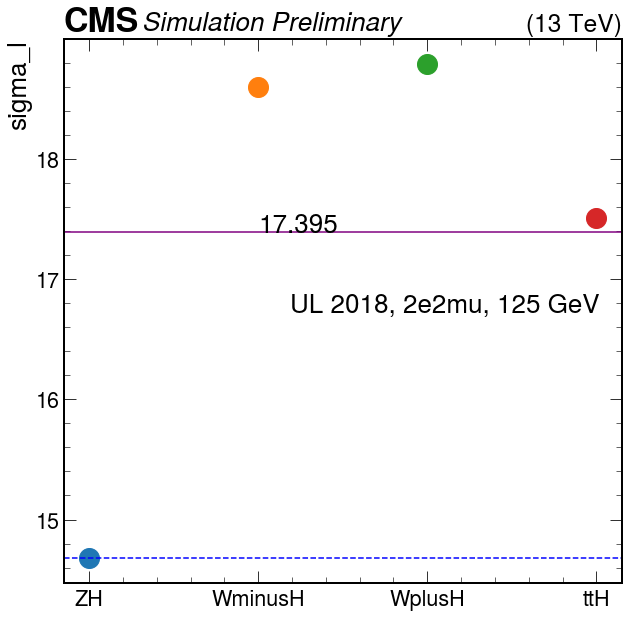

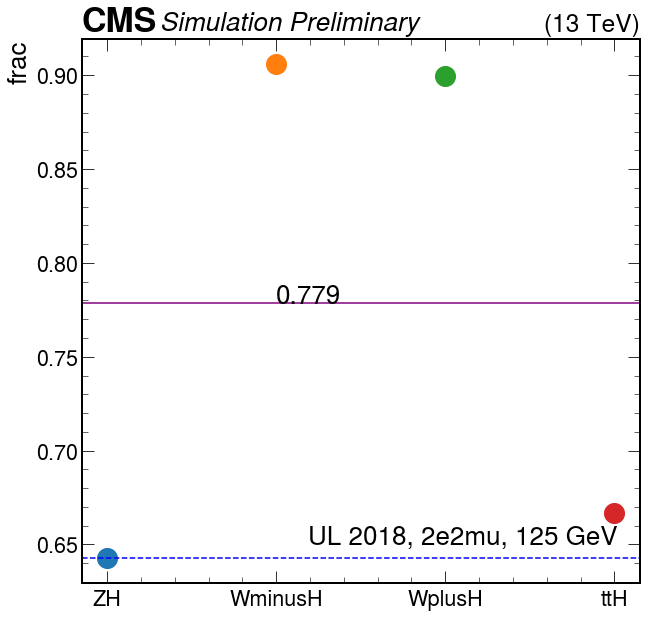

In [28]:
mH='125'
year = 2018
colors = ['b','r','g','darkorange']
VH_PMODES = ['ZH', 'WminusH', 'WplusH', 'ttH']
PARAMS = ['mean_l', 'sigma_l', 'frac']

pdf_landau_params = od()

for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
    fitparams = defaultdict(list)

    for pmode in VH_PMODES:
    
        _name = fs; _id = idx+1

        x = np.linspace(105, 140, 1000)
        if SUFFIX!='redTree':
            x = np.linspace(105, 160, 1000)

        zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)

        fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
        params = readParams(pmode, _name, year, fname = fname, mH=mH, toDict=True)
        for param_name in params:
            fitparams[param_name].append(params[param_name])
    
    landau_params = od()

    for param in PARAMS:
#         print(param, fs, np.mean(fitparams[param]))
        plt.figure()
        for idx, pmode in enumerate(VH_PMODES):
            plt.plot(pmode, fitparams[param][idx], 'o', markersize = 20)
            plt.ylabel(param)
        plt.axhline(fitparams[param][0], linestyle='--', color = 'b')
        plt.axhline(np.mean(fitparams[param]), linestyle = '-', color = 'purple')
        plt.annotate(round(np.mean(fitparams[param]),3), (1, np.mean(fitparams[param])))
        hep.cms.label(loc=0, label = 'Preliminary')
        plt.legend(title=f'UL {year}, {fs}, {mH} GeV', frameon = False)
        landau_params[param] = np.mean(fitparams[param])
    
    pdf_landau_params[fs] = landau_params

In [29]:
mH='125'
year = 2018
colors = ['b','r','g','darkorange']
VH_PMODES = ['ZH', 'WminusH', 'WplusH', 'ttH']
PARAMS = ['mean_l', 'sigma_l', 'frac']
ALL_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'mean_l', 'sigma_l', 'frac']

pdf_parameters = od()

for year in [2016, 2017, 2018]:    
    pdf_landau_params = od()

    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        fitparams = defaultdict(list)
        _name = fs; _id = idx+1

        fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %('ggH', SUFFIX, _name, year)
        ggH_params = readParams('ggH', _name, year, fname = fname, mH=mH)
        
        for pmode in VH_PMODES:            
        
            x = np.linspace(105, 140, 1000)
            if SUFFIX!='redTree':
                x = np.linspace(105, 160, 1000)

            zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)

            fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
            params = readParams(pmode, _name, year, fname = fname, mH=mH, toDict=True)
            for param_name in params:
                fitparams[param_name].append(params[param_name])

        landau_params = []

        for param in PARAMS:
            landau_params.append(np.mean(fitparams[param]))

        ggH_params.extend(landau_params)
        
        fs_params = od()
        
        for param, pdf_par in zip(ALL_PARAMS,ggH_params):
            fs_params[param] = pdf_par
            
        pdf_landau_params[fs] = fs_params
    
    pdf_parameters[year] = pdf_landau_params

In [30]:
mH='125'
year = 2018
colors = ['b','r','g','darkorange']
VH_PMODES = ['ZH', 'WminusH', 'WplusH', 'ttH']
PARAMS = ['mean_l', 'sigma_l', 'frac']
ALL_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'mean_l', 'sigma_l', 'frac']

pdf_shifts = od()

for year in [2016, 2017, 2018]:    
    pdf_landau_params = od()

    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        fitparams = defaultdict(list)
        _name = fs; _id = idx+1

        fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %('ggH', SUFFIX, _name, year)
        ggH_params = readShifts('ggH', _name, year, fname = fname, mH=mH)

        for pmode in VH_PMODES:            

            x = np.linspace(105, 140, 1000)
            if SUFFIX!='redTree':
                x = np.linspace(105, 160, 1000)

            zzmass, weight, chan = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)

            fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d.txt' %(pmode, SUFFIX, _name, year)
            params = readShifts(pmode, _name, year, fname = fname, mH=mH, toDict=True)

            for param_name in params:
                fitparams[param_name].append(params[param_name])

        landau_params = []

        for param in PARAMS:
            landau_params.append(np.mean(fitparams[param]))

        ggH_params.extend(landau_params)
        
        fs_params = od()
        
        for param, pdf_par in zip(ALL_PARAMS,ggH_params):
            fs_params[param] = pdf_par
            
        pdf_landau_params[fs] = fs_params
    
    pdf_shifts[year] = pdf_landau_params

## Save the final parameters 

For each year and final state, a single p.d.f. depending on $8$ parameters will be used. These are the $6$ parameters that define the double sided crystall ball and the $2$ parameters that define the MPV and sigma of the Landau.

In [31]:
www = f'/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/param/{WWW_DEST}'

In [32]:
for year in [2016, 2017, 2018]:
    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        with open(f'{www}/fitParams/sim_massParam_HIG21009PDF_{SUFFIX}_{fs}_{year}.txt', 'w') as f:
            for param in ALL_PARAMS:
                if param!='frac':
                    f.write(f'{param}_ALL_{year} \t {pdf_parameters[year][fs][param]}+{pdf_shifts[year][fs][param]}*(MH-125)\n')
                else:
                    f.write(f'{param}_ALL_{year} \t {pdf_parameters[year][fs][param]}\n')
        f.close()